In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [4]:
import sys, os
sys.path.append('../src')

In [5]:
from plot_utils import (
    get_weights,
    plot_weight_distribution,
    plot_regret,
    plot_total_regret,
    plot_regret_max,
    plot_regret_cl,
    winning_policy
)

from simulation_utils import (
    round_simulation
)

In [6]:
from online_policies import ( 
    ThompsonSamplingPolicy,
    GreedyPolicy,
    UCBPolicy,
    RandomPolicy,
)

In [7]:
# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [8]:
result_folder = "data/results_uniform_features_search"
os.makedirs( f"../{result_folder}", exist_ok=True)


In [9]:
experiment_params_name = [
"nArms",    "nPerRound",  "nRounds",    "nFeatures",    "lambda",   "alpha",    "nSims",    "seed"
]
experiment_params_nums = [


# [10,         1,          100,          1,              1,            .1,         100,         66],
[10,         1,          100,          10,              .1,            .01,         10,         66],




]

nArms = [2, 10]
nPerRounds = [1, 2]
nRounds = [100]
nFeatures = [1, 2, 3]
lambdas = [1, 10]
alphas = [.1, 1, 10]
nSims = [100]
seeds = [66]
experiment_params_nums = []
for nArm in nArms:
    for nPerRound in nPerRounds:
        for nRound in nRounds:
            for nFeature in nFeatures:
                for lambda_ in lambdas:
                    for alpha in alphas:
                        for nSim in nSims:
                            for seed in seeds:
                                experiment_params_nums.append([nArm, nPerRound, nRound, nFeature, lambda_, alpha, nSim, seed])


experiment_params_df = pd.DataFrame(experiment_params_nums, columns=experiment_params_name)
experiment_params_df

nArms  nPerRound  nRounds  nFeatures  lambda  alpha  nSims  seed
0       2          1      100          1       1    0.1    100    66
1       2          1      100          1       1    1.0    100    66
2       2          1      100          1       1   10.0    100    66
3       2          1      100          1      10    0.1    100    66
4       2          1      100          1      10    1.0    100    66
..    ...        ...      ...        ...     ...    ...    ...   ...
67     10          2      100          3       1    1.0    100    66
68     10          2      100          3       1   10.0    100    66
69     10          2      100          3      10    0.1    100    66
70     10          2      100          3      10    1.0    100    66
71     10          2      100          3      10   10.0    100    66

[72 rows x 8 columns]

In [10]:
# # regret analysis
seed = experiment_params_nums[0][-1]
print(f"Seed: {seed}")
np.random.seed(seed)
for param_index in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[param_index]
    print(f"Running simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    
    # do experiment
    experiment_df = pd.DataFrame()
    for simulation in range(n_sims):
        print(f"Running simulation {simulation}")
        # instance of TS
        # we generate 1 more true weight to the starting n_dim to simulate the new feature
        # generate true weights based on Gaussian distribution rather than uniform
        std = np.sqrt(1/lambda_)
        true_weights = np.random.normal(0, std, n_dim + 1)
        policy_params = {'lambda_': lambda_, 'alpha': alpha, 'n_dim': n_dim, 
                         'true_weights_full': true_weights,
                         'n_data_point_per_round': n_data_point_per_round}

        ts_lr = ThompsonSamplingPolicy(**policy_params)
        exploit_lr = GreedyPolicy(**policy_params)
        ucb_lr = UCBPolicy(**policy_params)
        random_lr = RandomPolicy(**policy_params)
        
        dp_dict = {'ts_lr': ts_lr, 
                'exploit_lr': exploit_lr,
                'ucb_lr': ucb_lr,
                # 'random_lr': random_lr
                }
        
        #Step 1: online training for the first n_rounds
        for i in range(n_rounds):
            # Generate featured data with a distribution rather than uniform
            X_full = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            # X_full = np.random.normal(0, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            X = X_full[:, :, :-1]
            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim, dp_dict, simulation, i, X_full, X)

            experiment_df = pd.concat([experiment_df, round_df])

        # Step 2:
        # start introducing new features
        for key, online_lr in dp_dict.items():
            # online_lr.add_new_feature()
            online_lr.add_new_feature()

        # Step 3: continue to train for another n_rounds with the new feature
        for i in range(n_rounds, 2*n_rounds):
            X_full = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            # X_full = np.random.normal(0, 1, (n_data_point_per_round, n_providers, n_dim + 1))

            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim+1, dp_dict, simulation, i, X_full, X_full)

            experiment_df = pd.concat([experiment_df, round_df])



    
    # save experiment_df to a file with the experiment parameters in the file name
    experiment_df.to_csv(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.csv", index=True)
    # also save it to a pickle file
    experiment_df.to_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")




Seed: 66
Running simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 0.1, 100 simulations
Running simulation 0
Running simulation 1
Running simulation 2
Running simulation 3
Running simulation 4
Running simulation 5
Running simulation 6
Running simulation 7
Running simulation 8
Running simulation 9
Running simulation 10
Running simulation 11
Running simulation 12
Running simulation 13
Running simulation 14
Running simulation 15
Running simulation 16
Running simulation 17
Running simulation 18
Running simulation 19
Running simulation 20
Running simulation 21
Running simulation 22
Running simulation 23
Running simulation 24
Running simulation 25
Running simulation 26
Running simulation 27
Running simulation 28
Running simulation 29
Running simulation 30
Running simulation 31
Running simulation 32
Running simulation 33
Running simulation 34
Running simulation 35
Running simulation 36
Running simulation 37
Running simulation 38
Running simulation 39
Run

Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    2.034363
exploit_lr  199.0    2.772069
ucb_lr      199.0    1.963736
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    2.568916
exploit_lr  199.0    2.035369
ucb_lr      199.0    2.197602
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    9.260880
exploit_lr  199.0    1.604445
ucb_lr      199.0    9.208614
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    1.987722
exploit_lr  199.0    2.294593
ucb_lr      

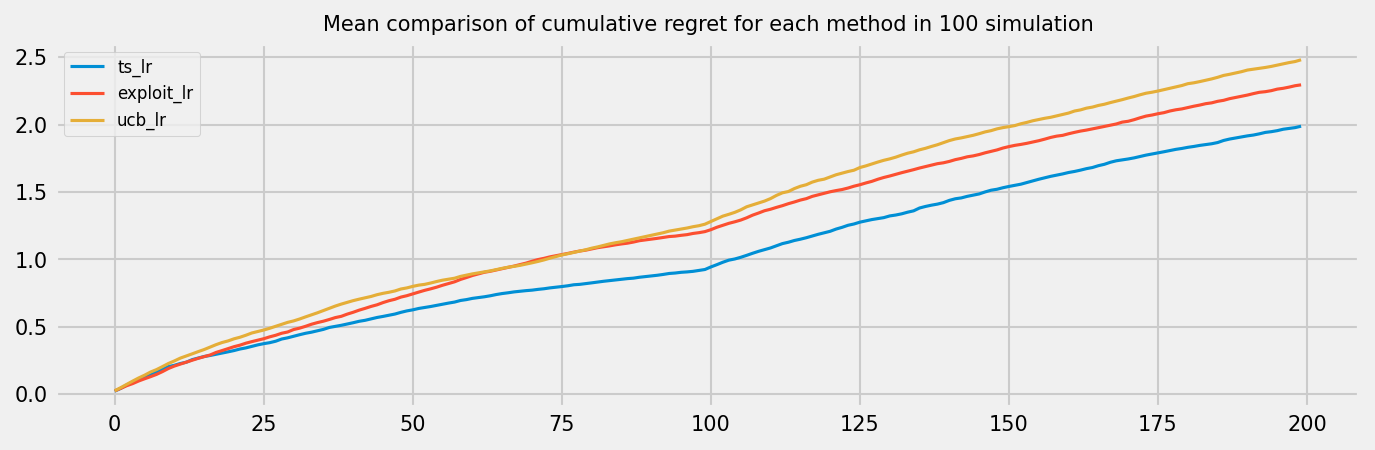

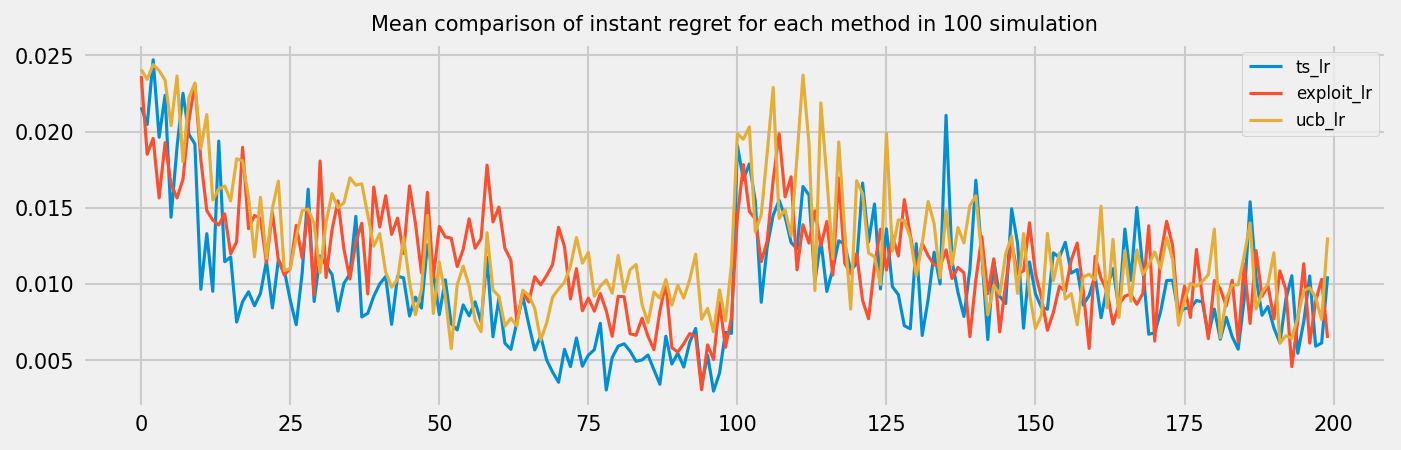

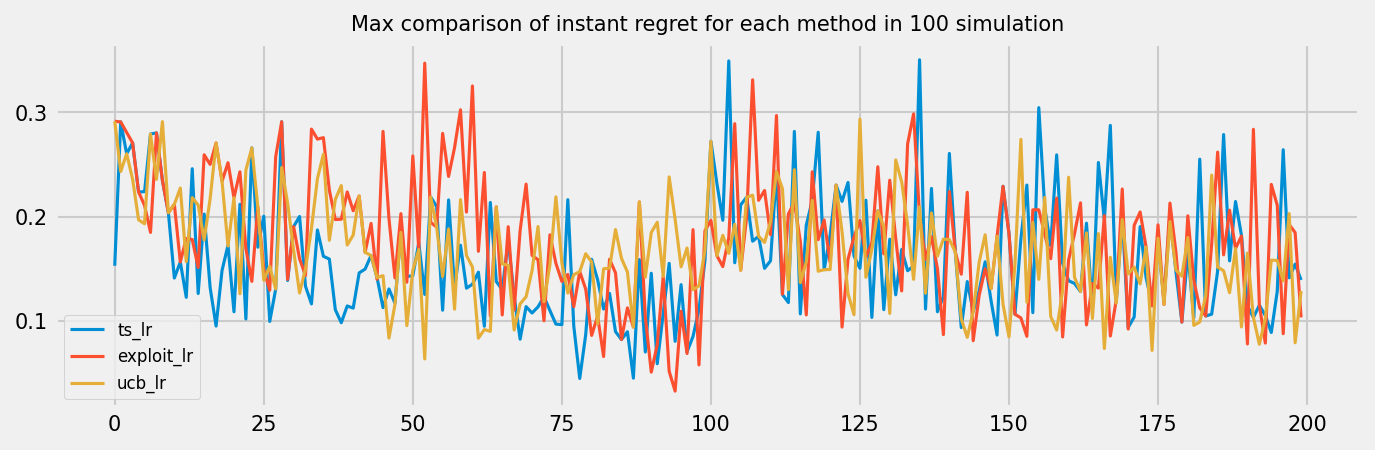

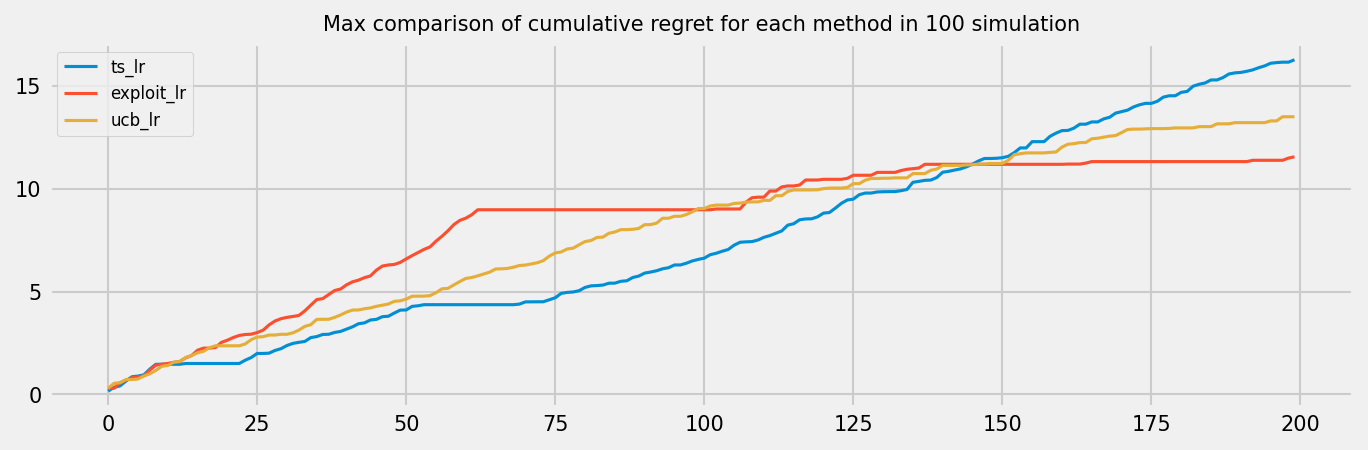

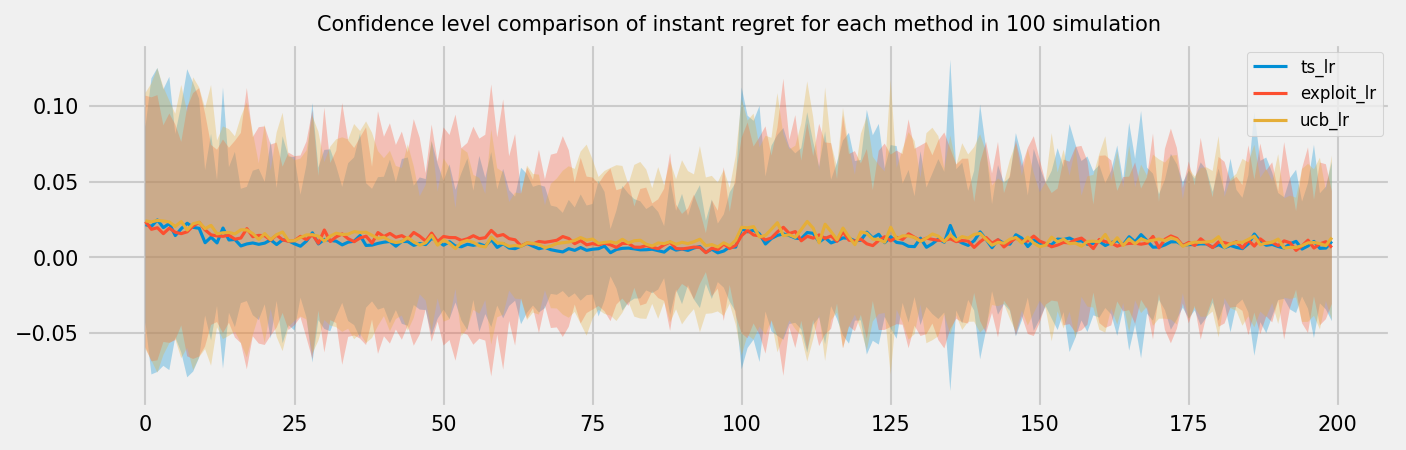

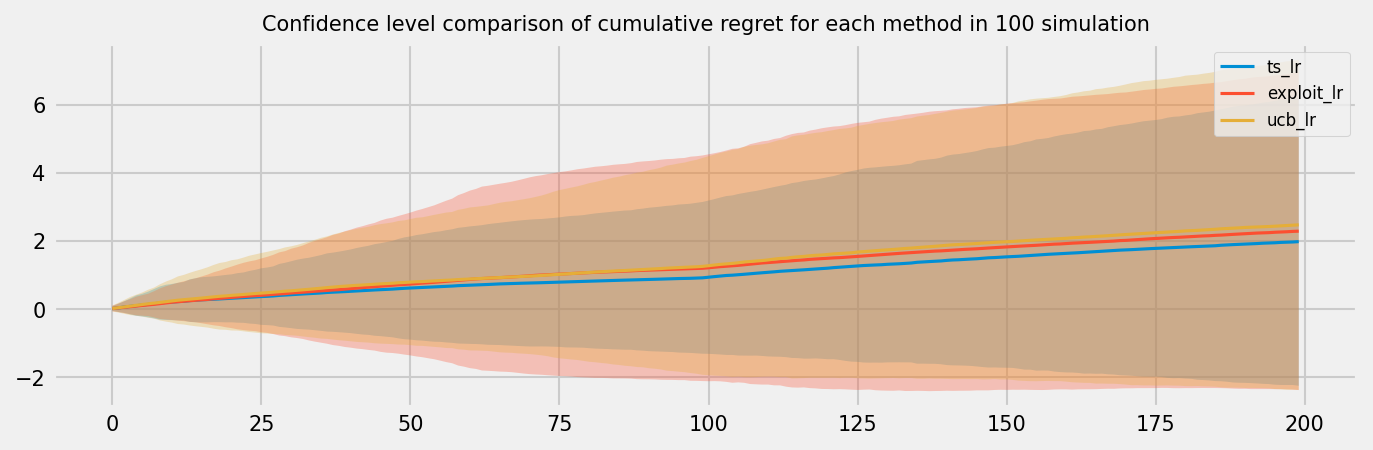

<Figure size 1500x450 with 0 Axes>

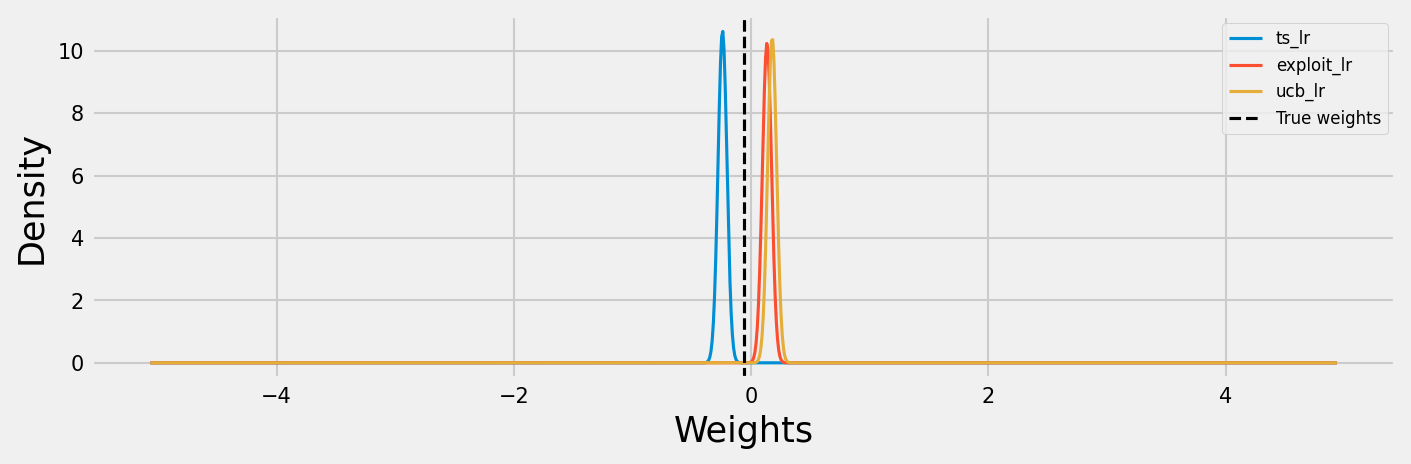

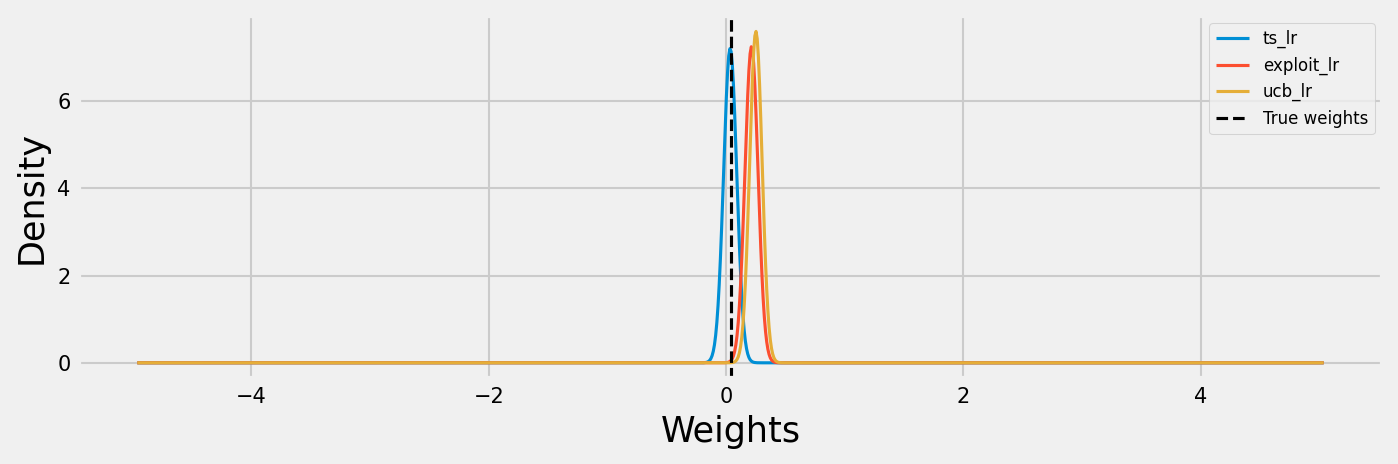

Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    2.726071
exploit_lr  199.0    2.159102
ucb_lr      199.0    2.614716
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    4.642796
exploit_lr  199.0    2.628205
ucb_lr      199.0    4.707435
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    2.805470
exploit_lr  199.0    2.591244
ucb_lr      199.0    2.521434
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    3.537707
exploit_lr  199.0    2.498591
ucb_lr      1

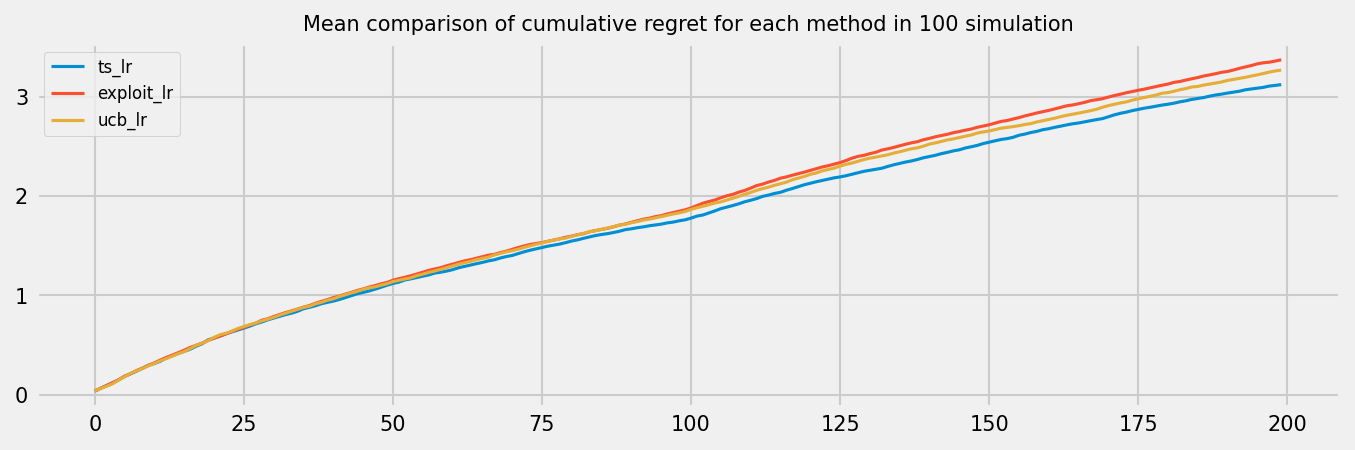

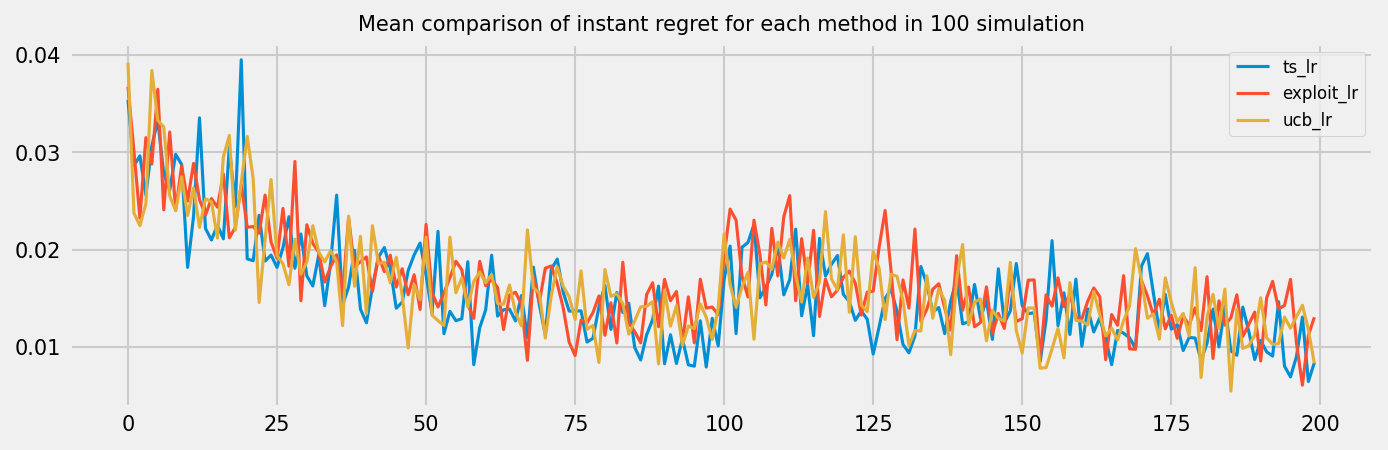

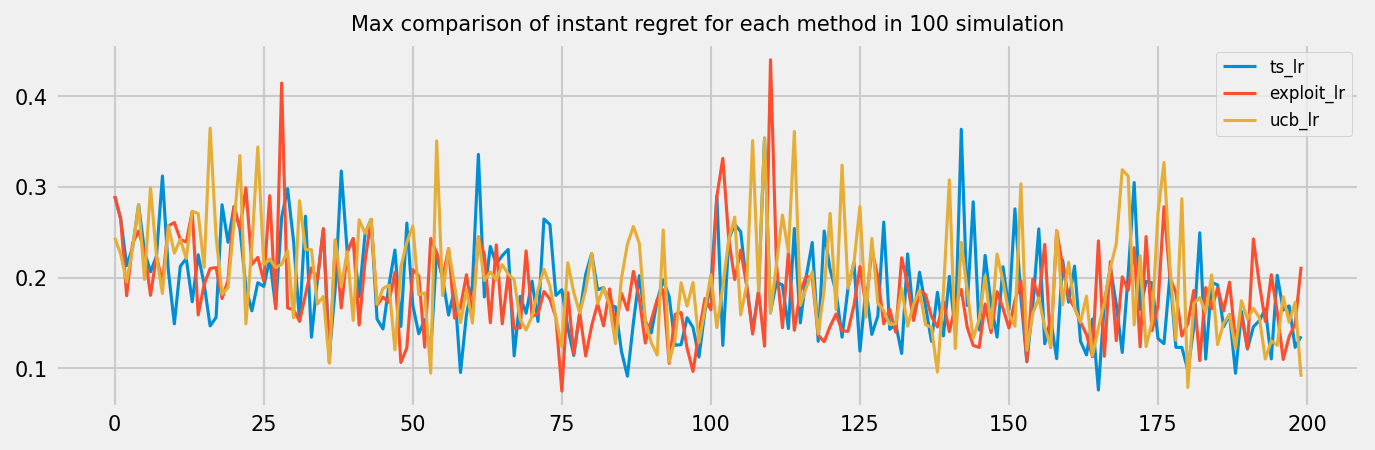

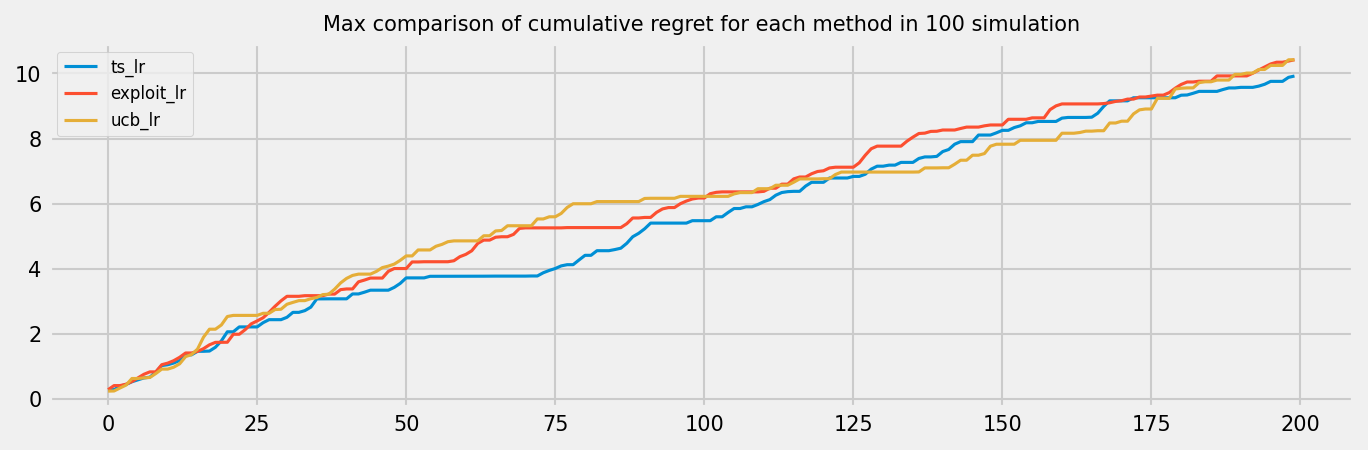

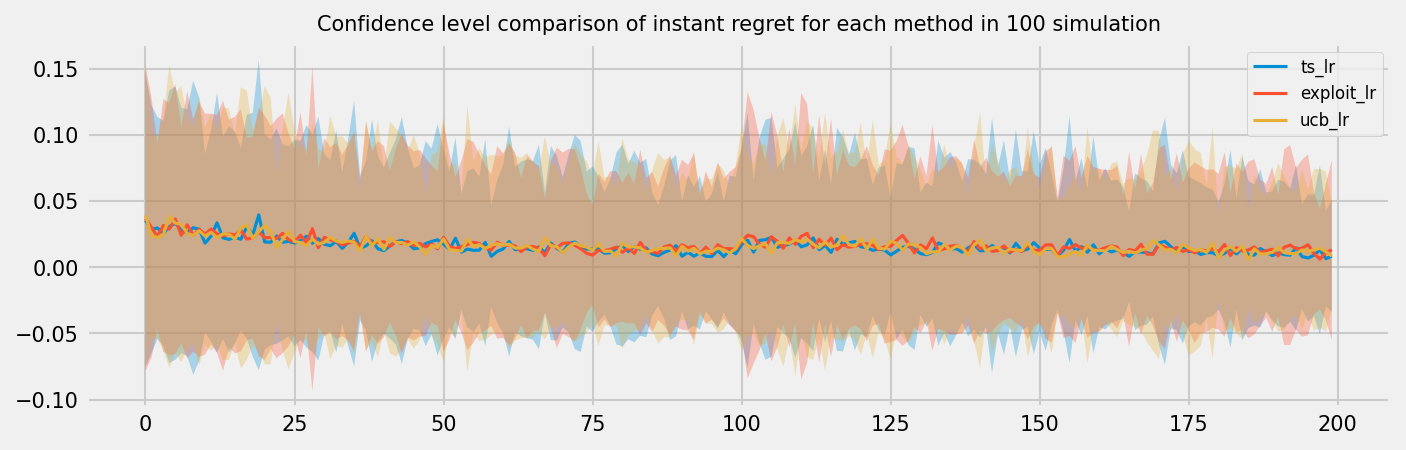

<Figure size 1500x450 with 0 Axes>

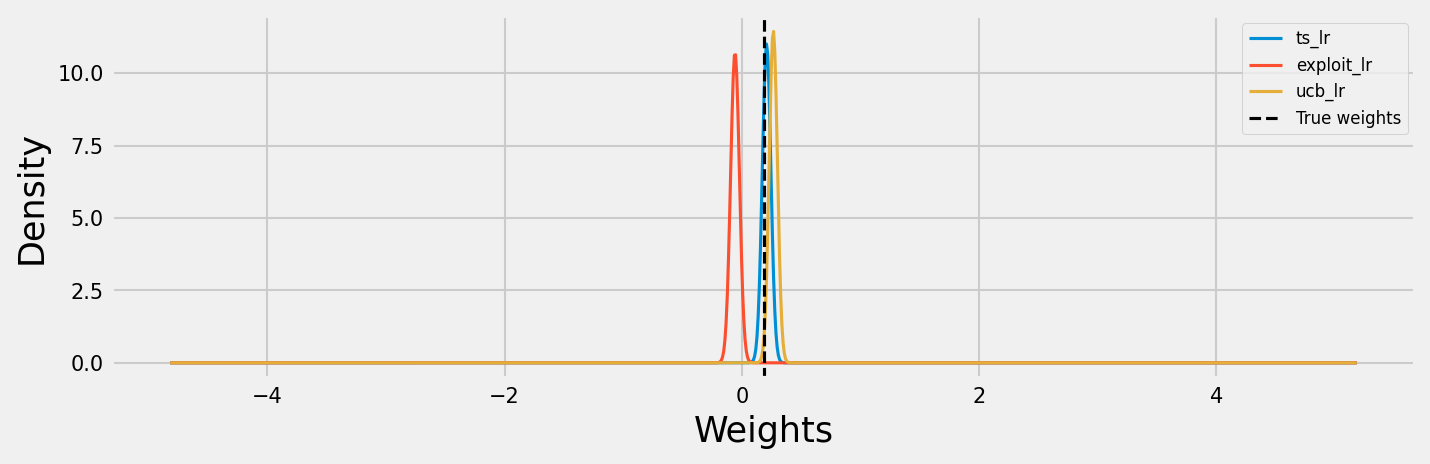

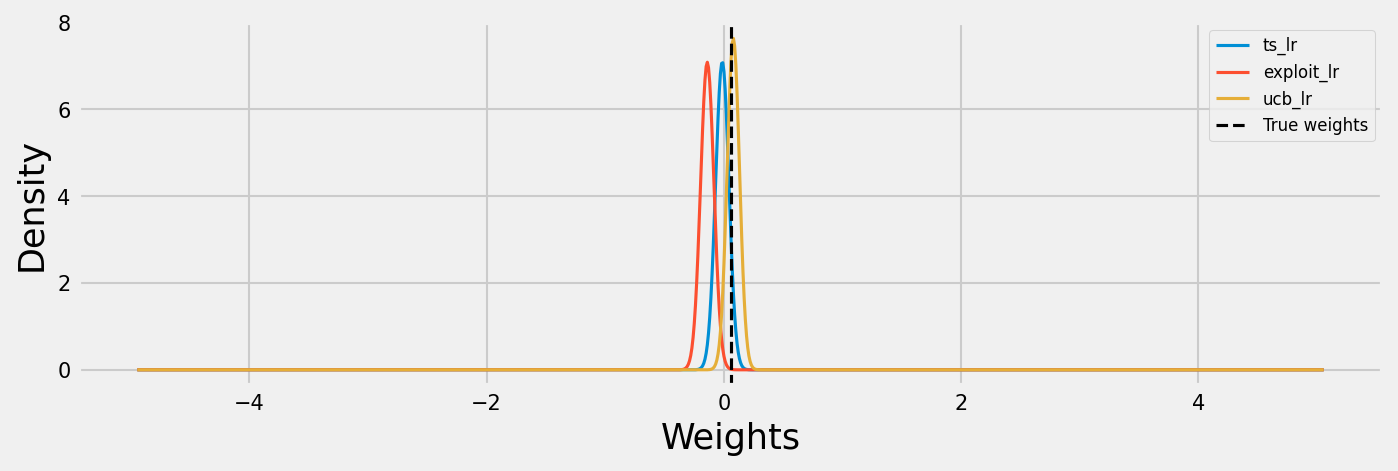

Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    5.839156
exploit_lr  199.0    2.528430
ucb_lr      199.0    5.872446
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    3.116114
exploit_lr  199.0    3.356717
ucb_lr      199.0    3.206660
Name: regret_cumsum, dtype: float64


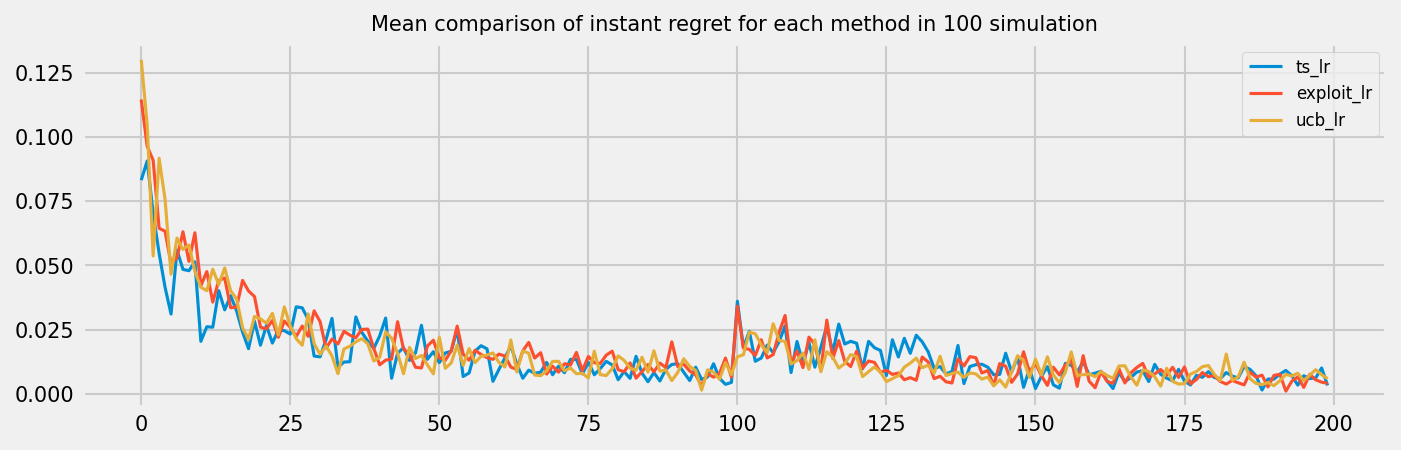

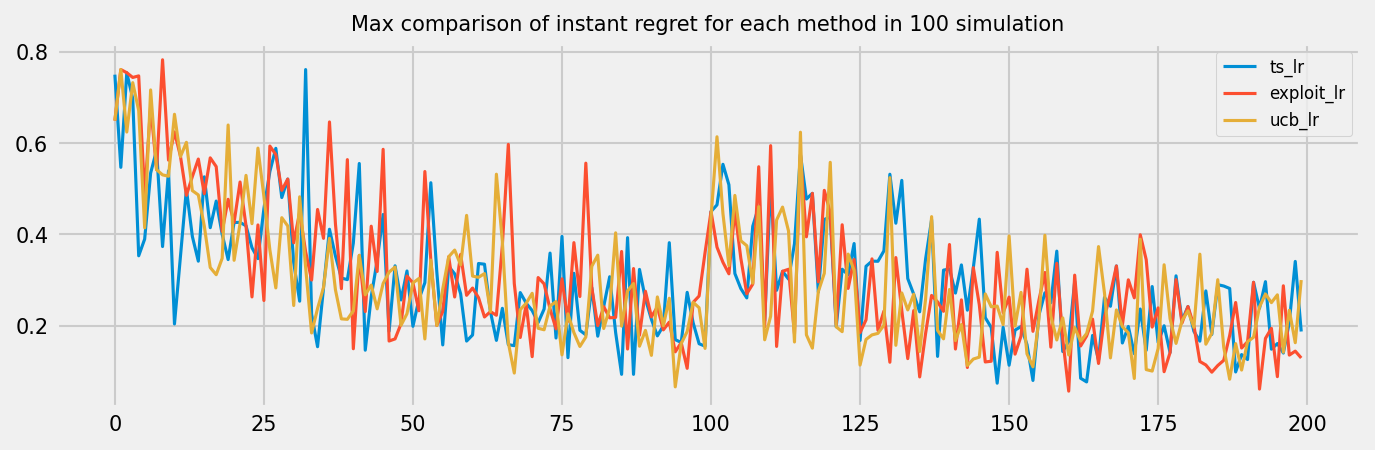

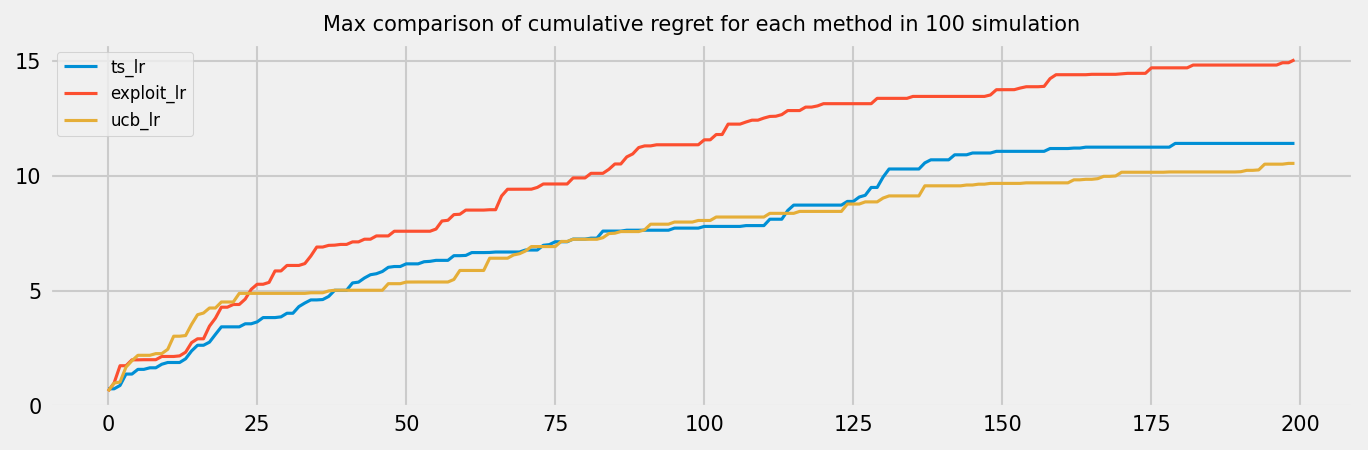

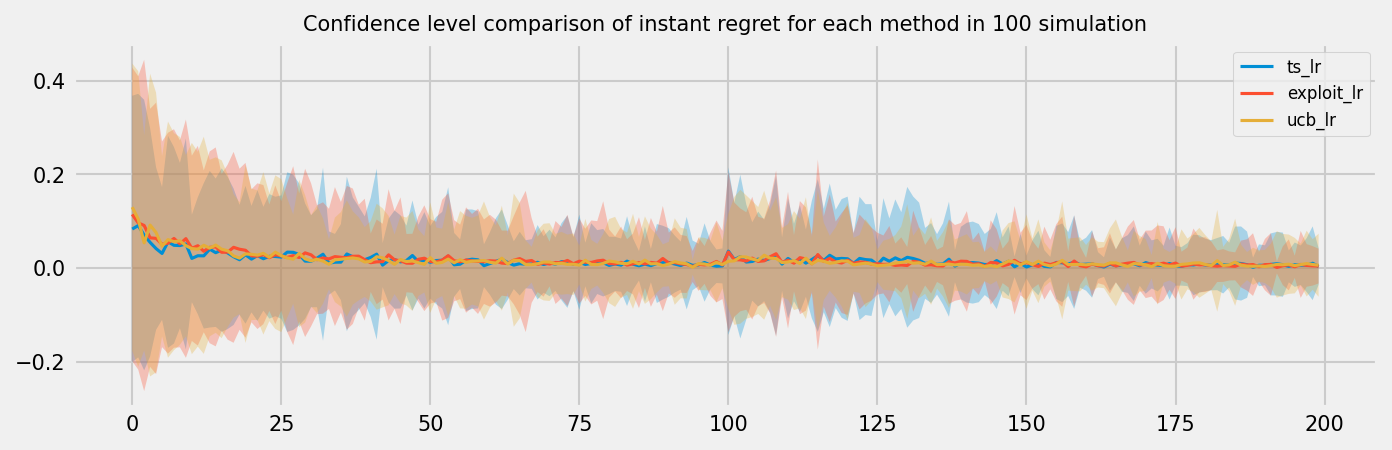

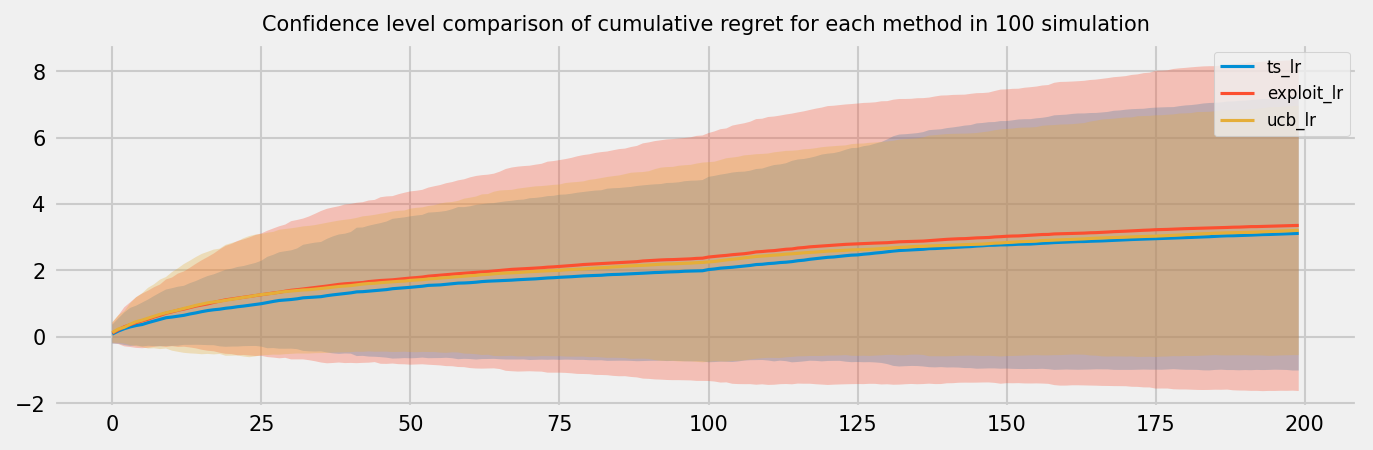

<Figure size 1500x450 with 0 Axes>

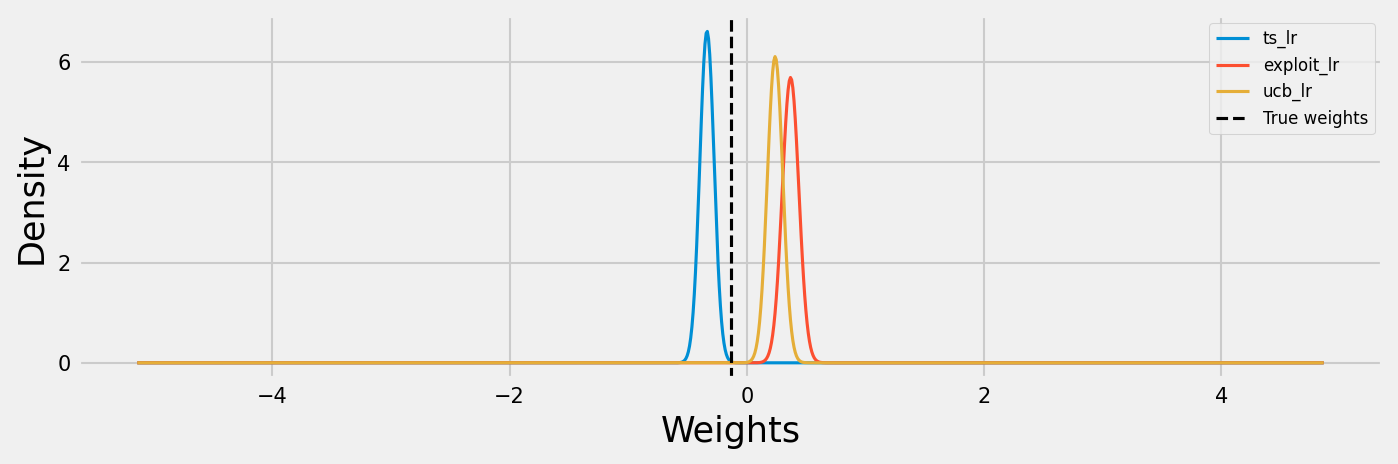

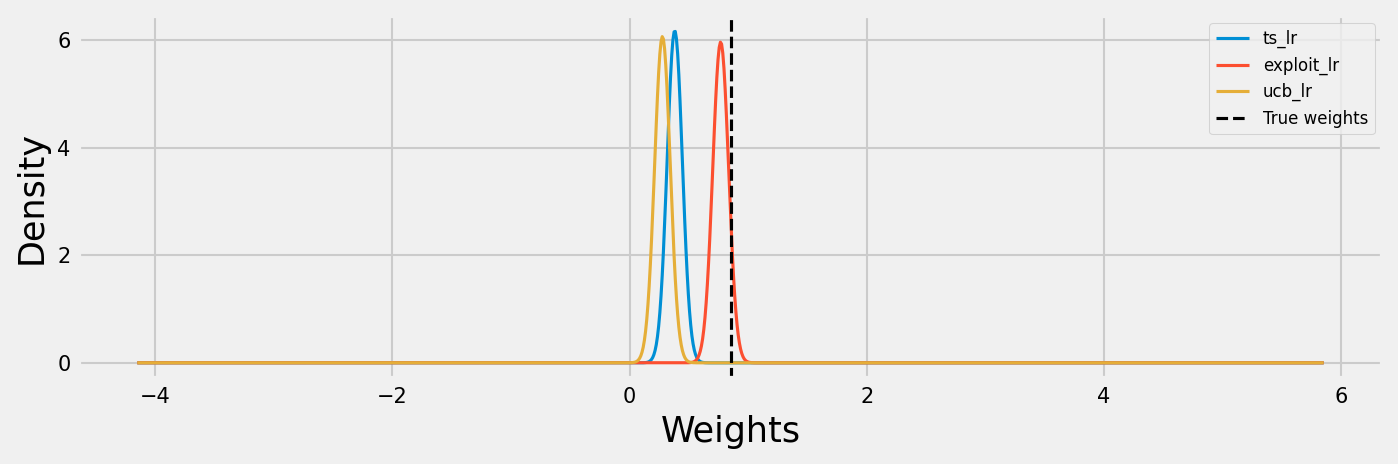

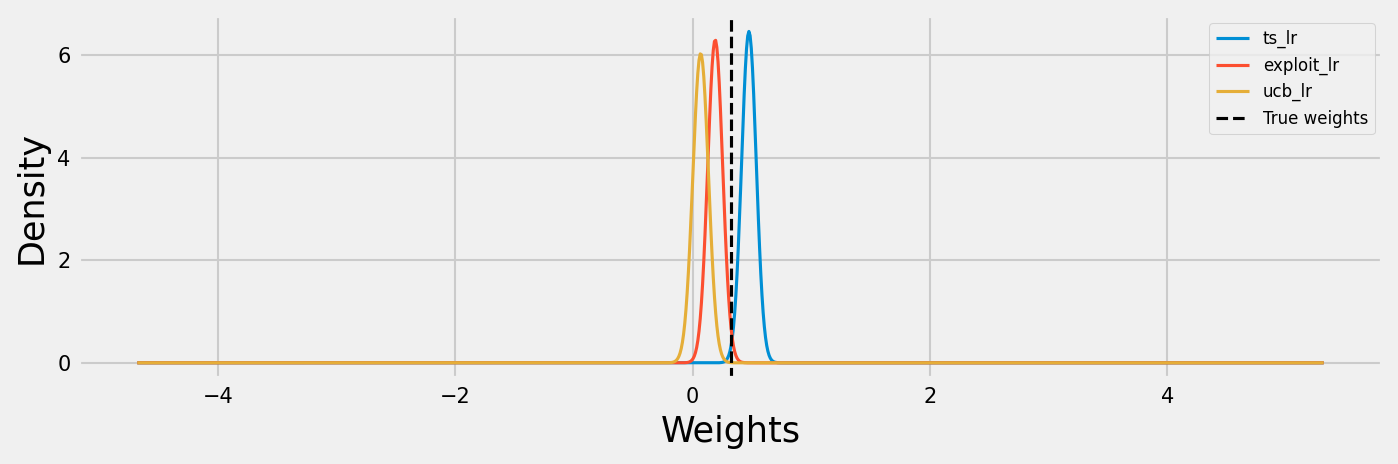

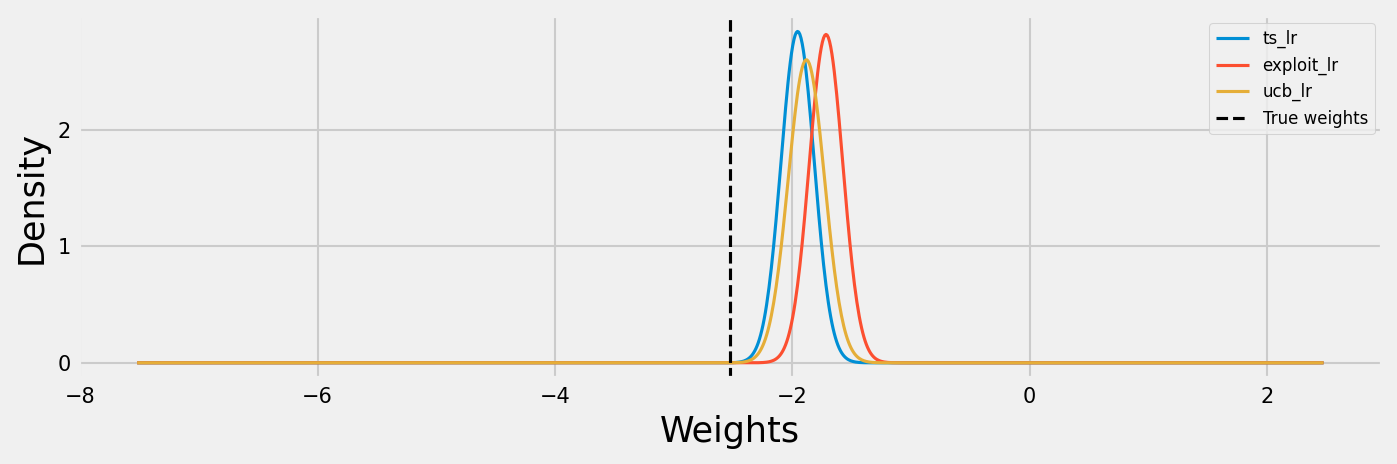

Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    4.172686
exploit_lr  199.0    3.143205
ucb_lr      199.0    3.254875
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    13.939616
exploit_lr  199.0     3.314657
ucb_lr      199.0    10.617353
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    4.170644
exploit_lr  199.0    3.622245
ucb_lr      199.0    3.436561
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    4.175733
exploit_lr  199.0    3.260536
ucb_lr    

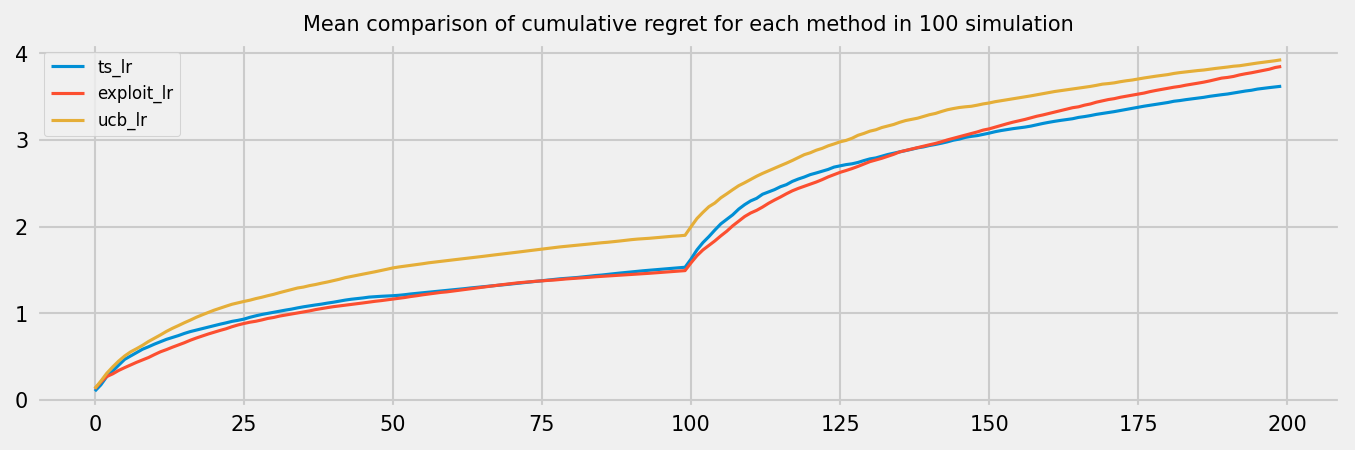

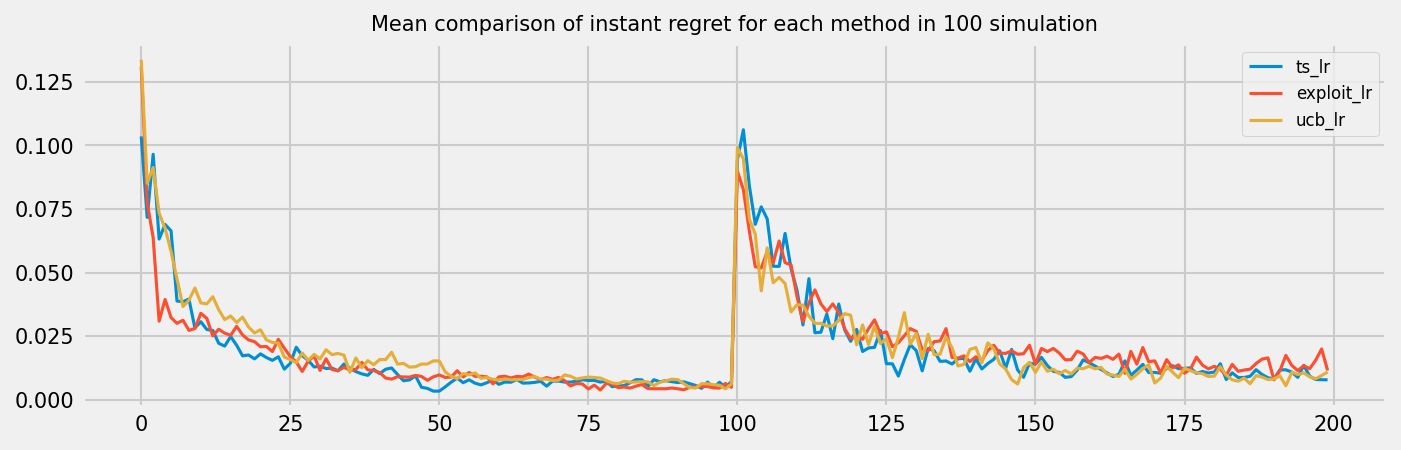

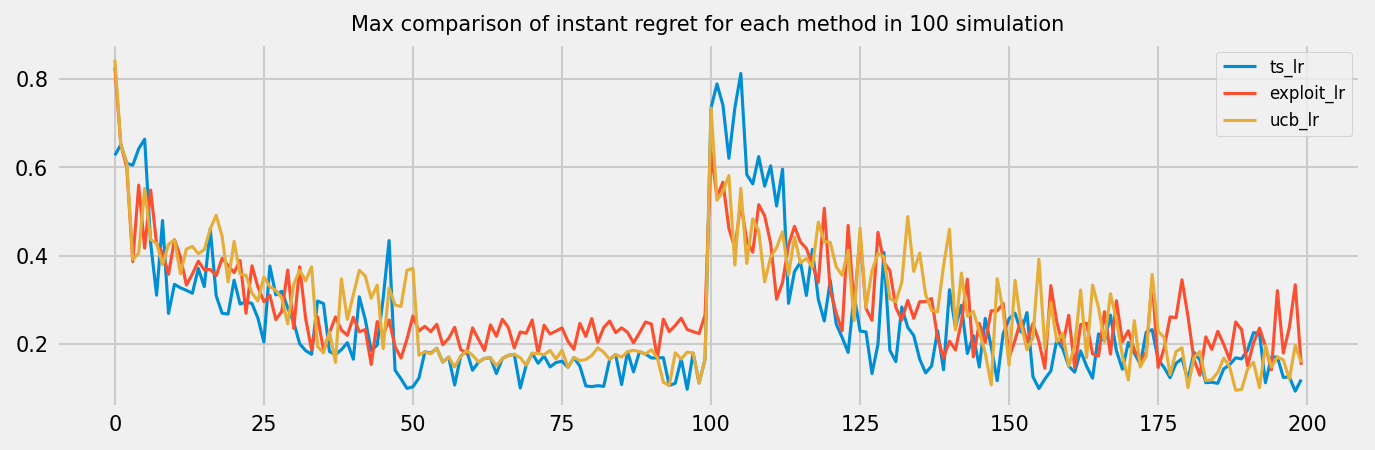

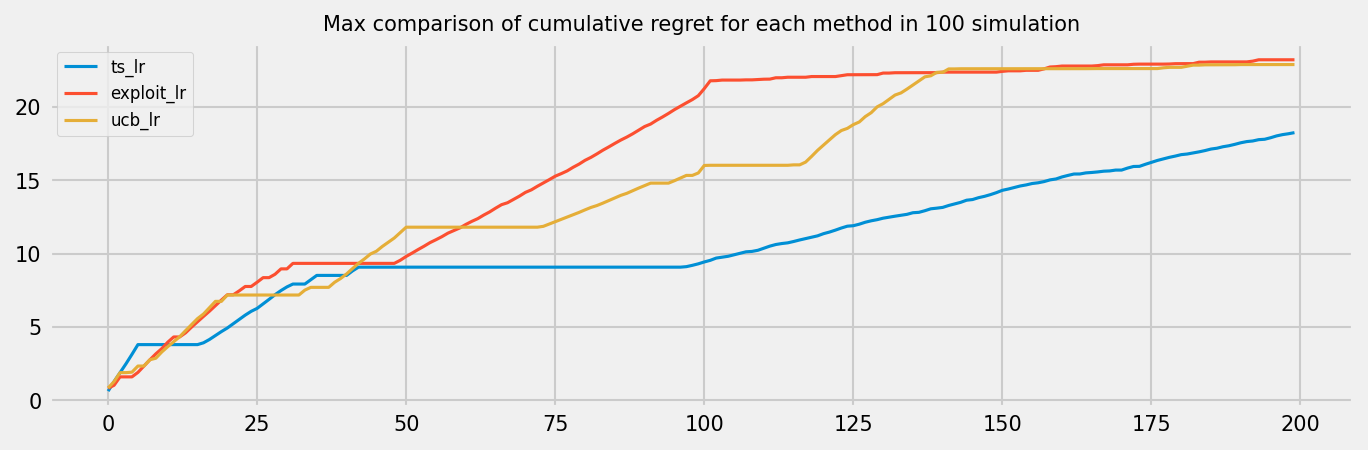

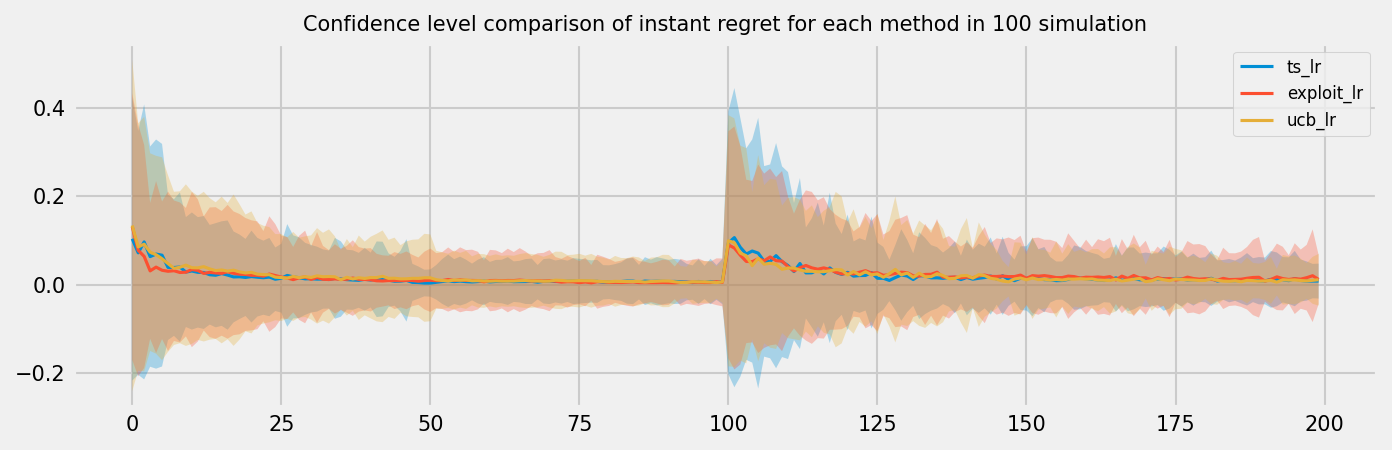

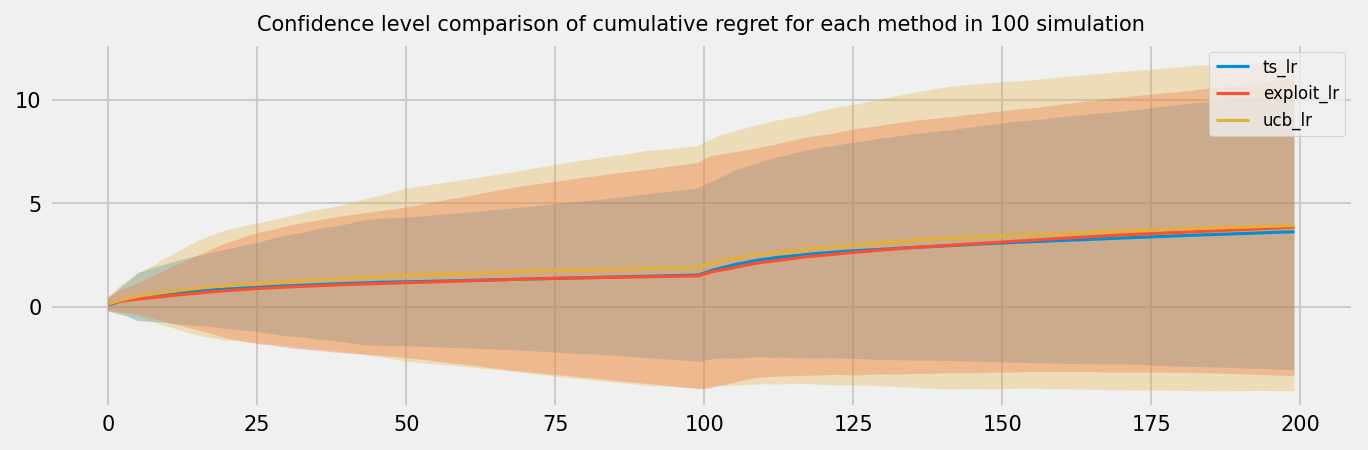

<Figure size 1500x450 with 0 Axes>

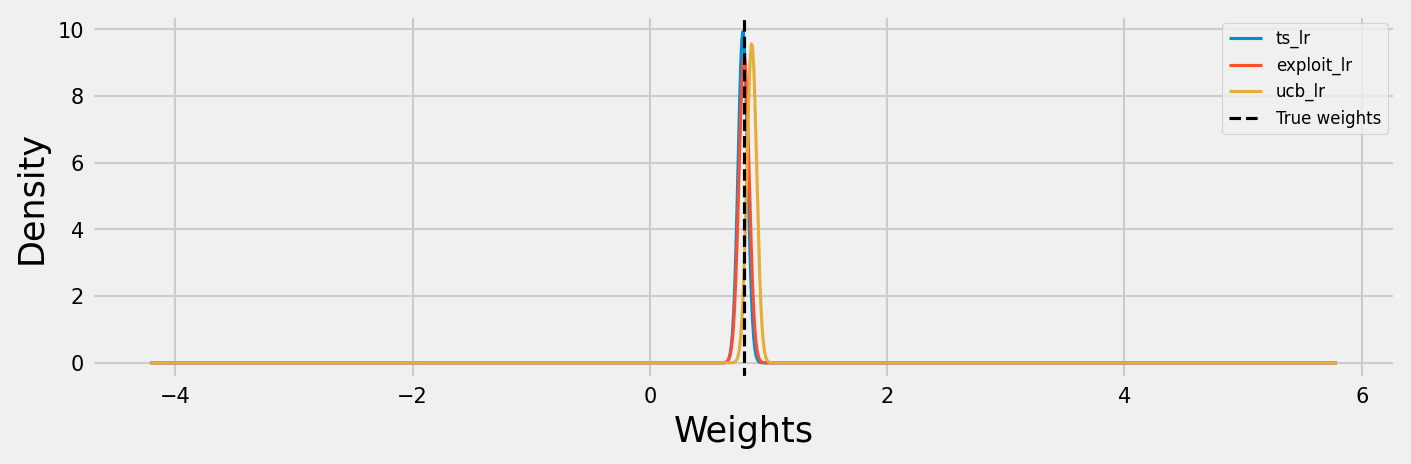

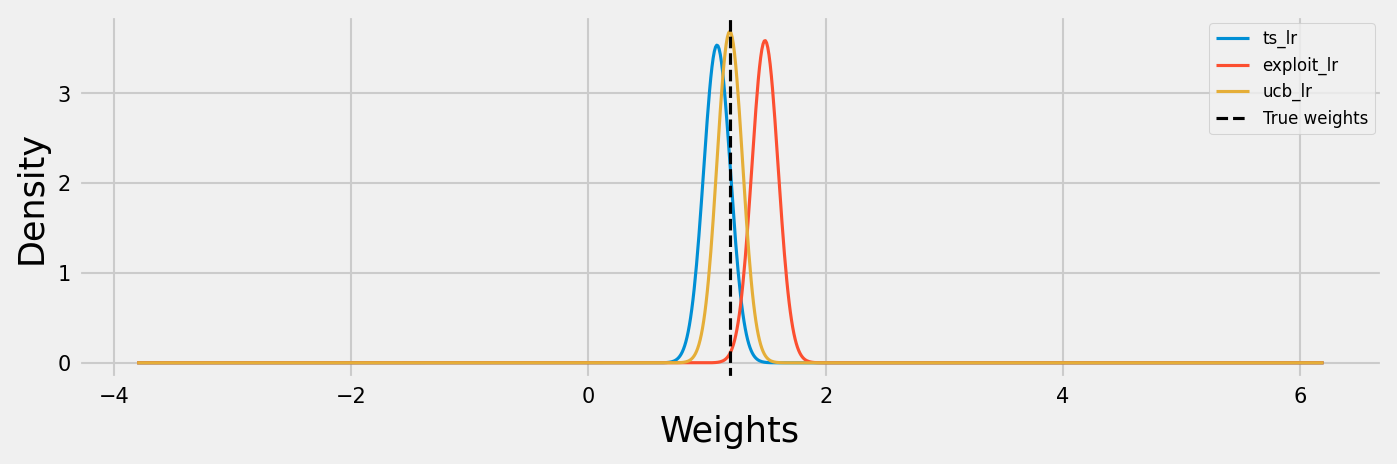

Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    4.612191
exploit_lr  199.0    4.030437
ucb_lr      199.0    3.327121
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    16.271018
exploit_lr  199.0     4.255641
ucb_lr      199.0     8.635820
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    4.763553
exploit_lr  199.0    4.281581
ucb_lr      199.0    4.547158
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    4.274714
exploit_lr  199.0    4.032168
ucb_lr

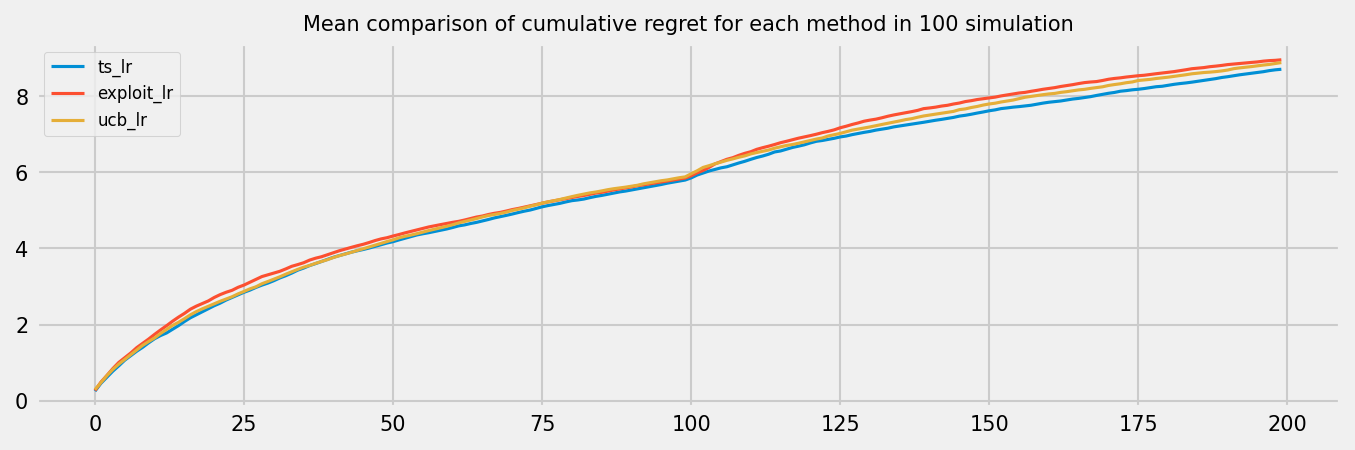

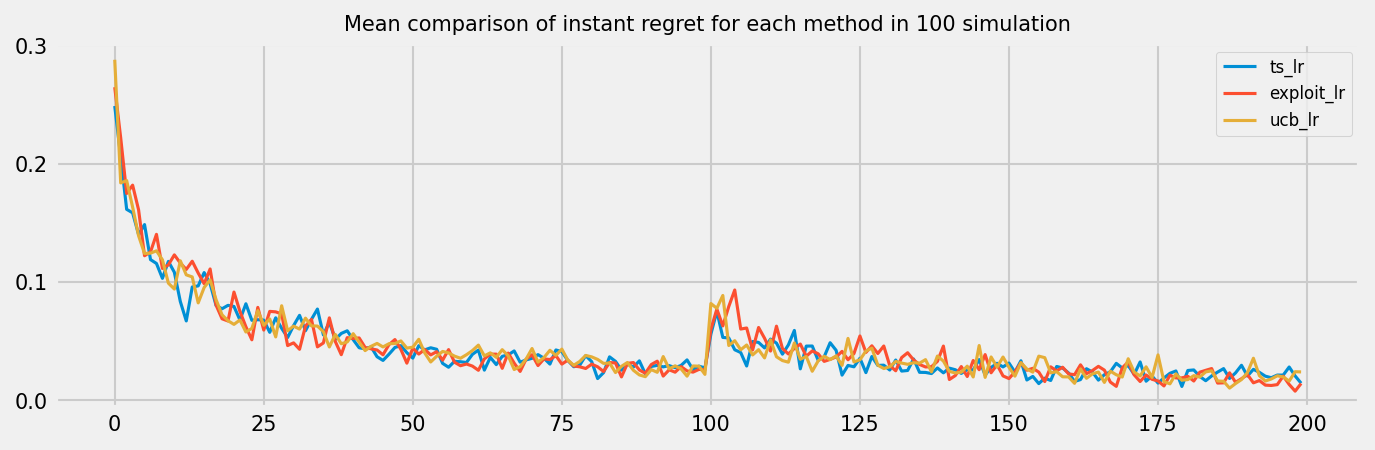

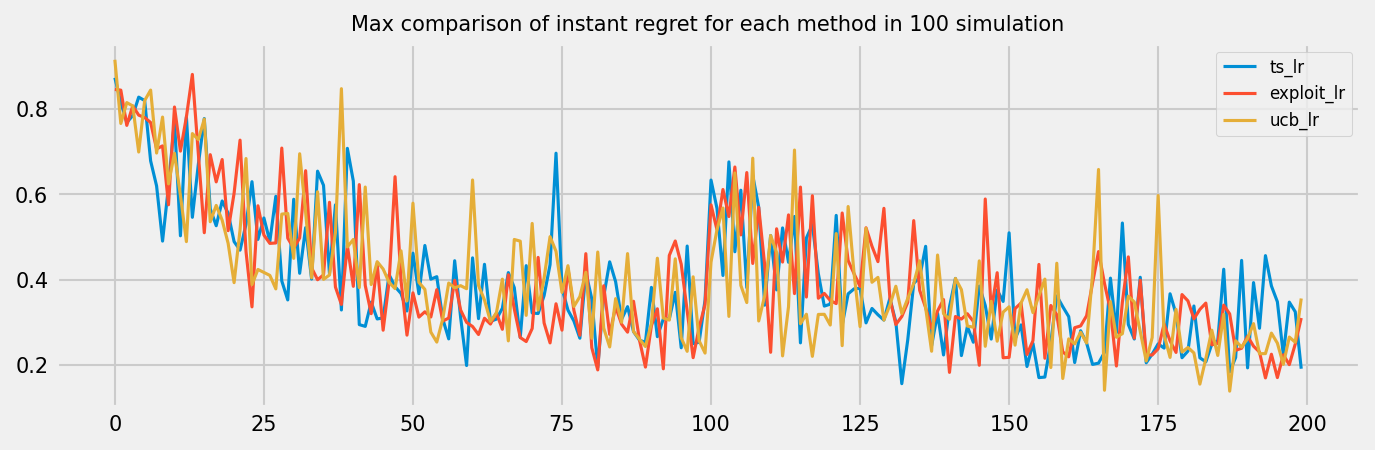

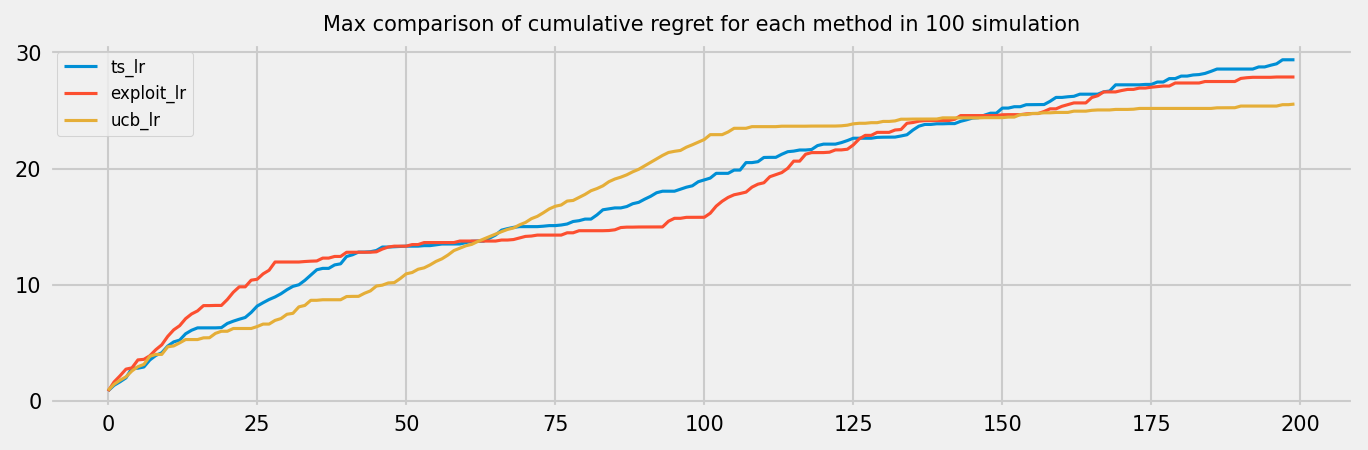

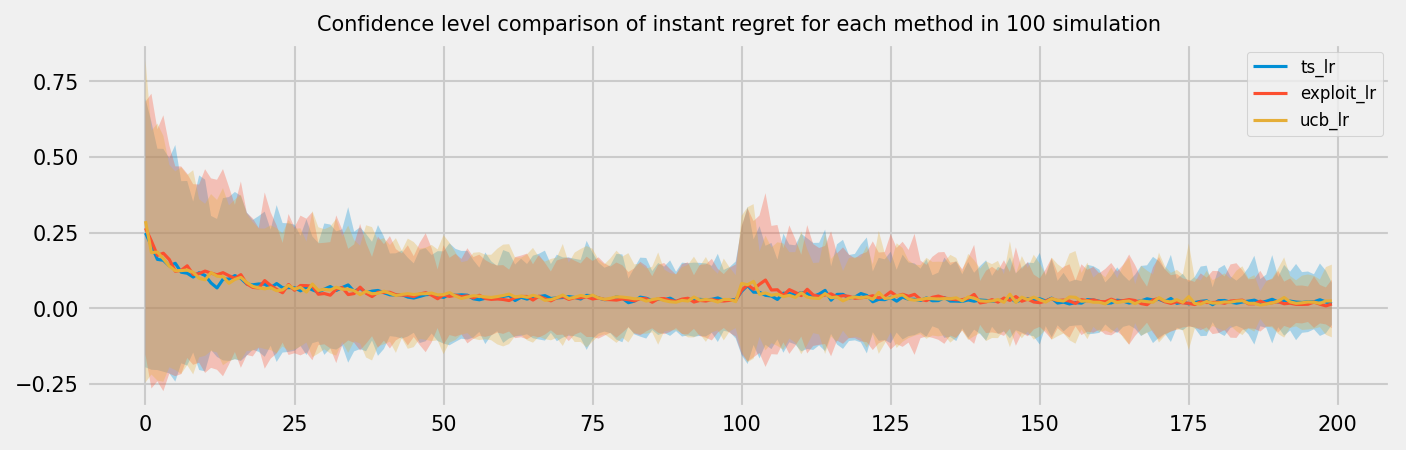

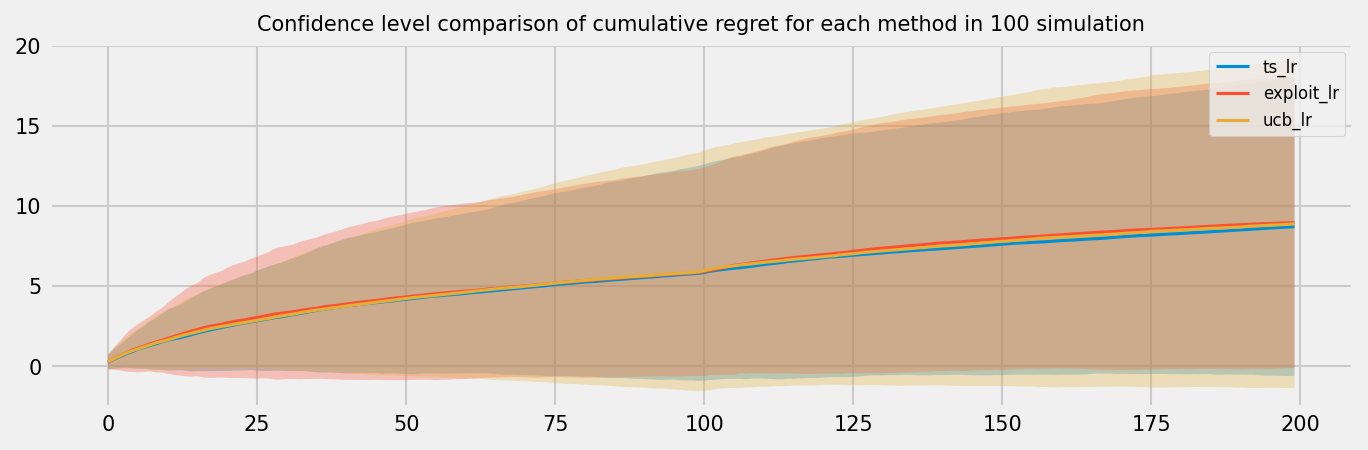

<Figure size 1500x450 with 0 Axes>

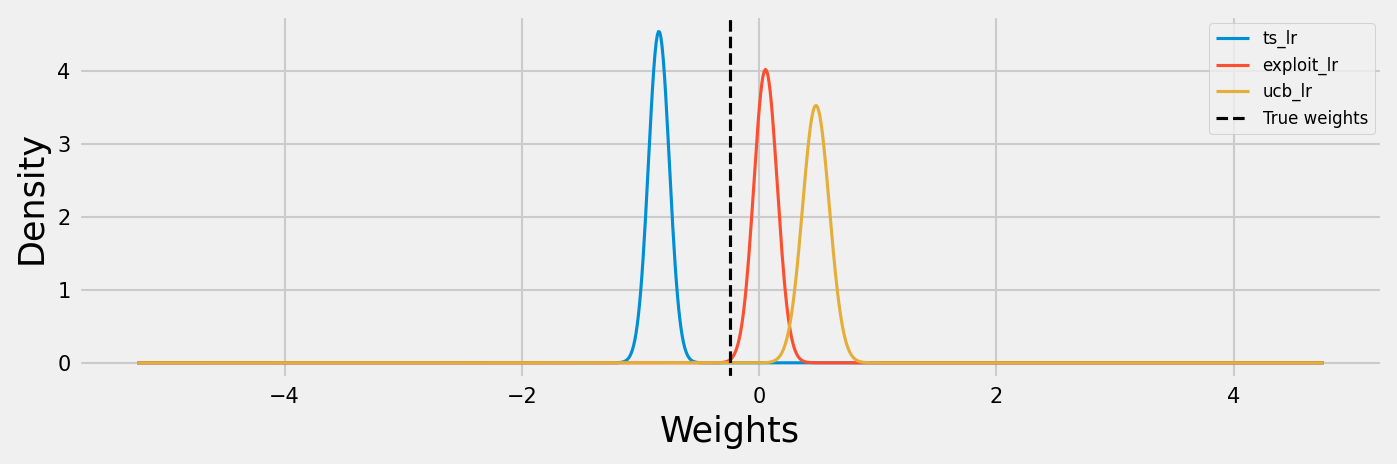

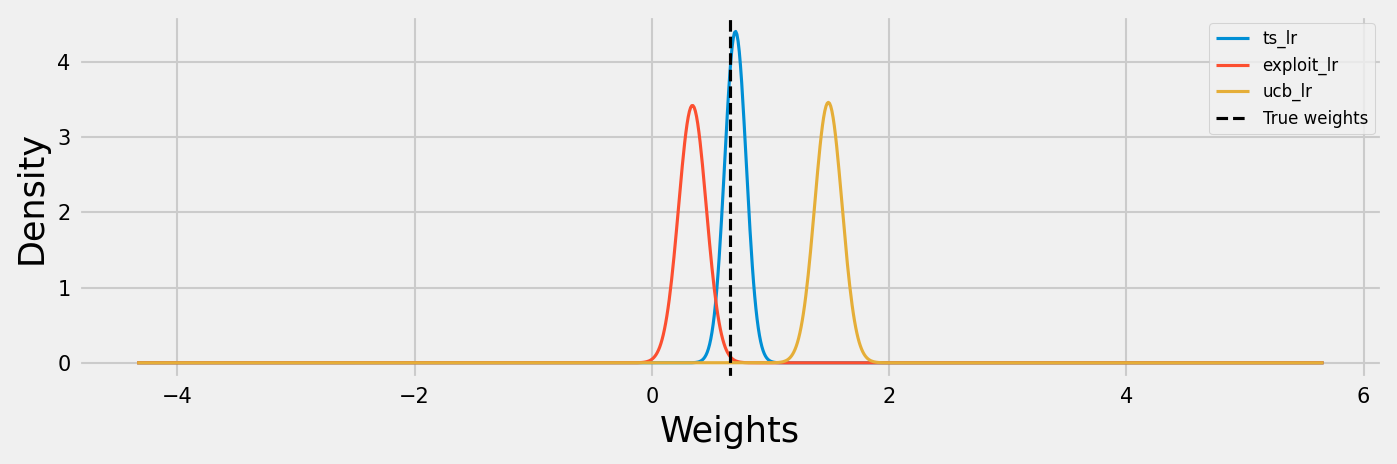

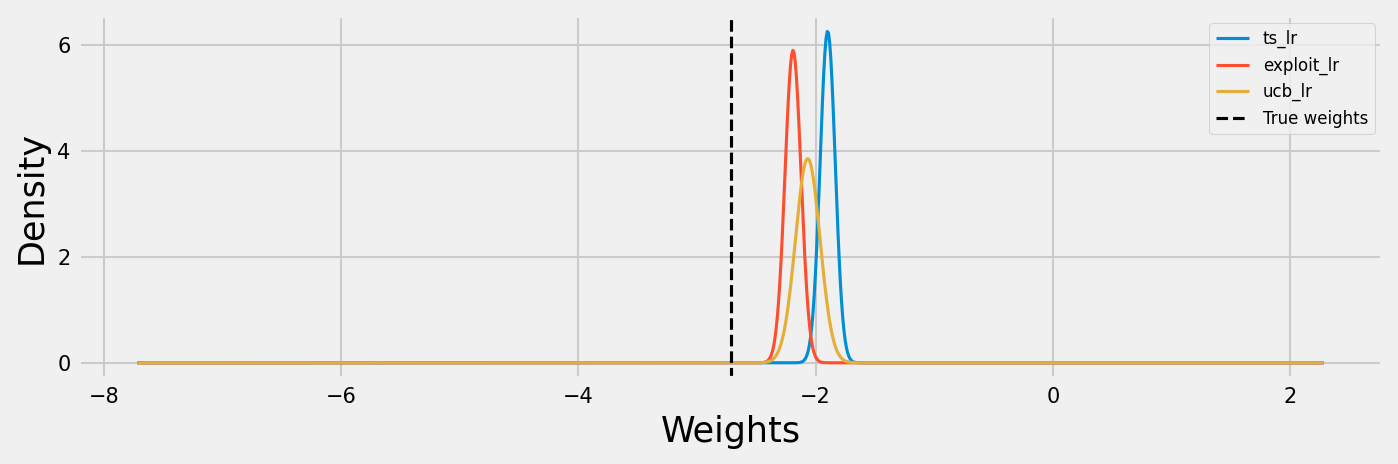

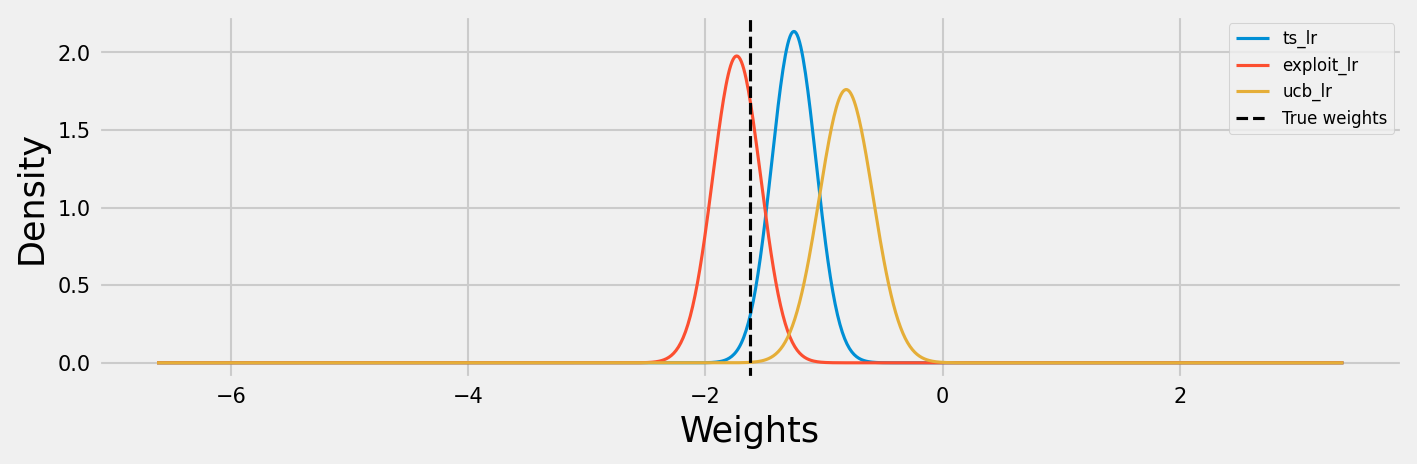

Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    9.727405
exploit_lr  199.0    7.269899
ucb_lr      199.0    7.664119
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    31.141847
exploit_lr  199.0     8.228714
ucb_lr      199.0    15.299065
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    10.254982
exploit_lr  199.0     9.438959
ucb_lr      199.0     9.033705
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    8.819719
exploit_lr  199.0    8.772624
ucb

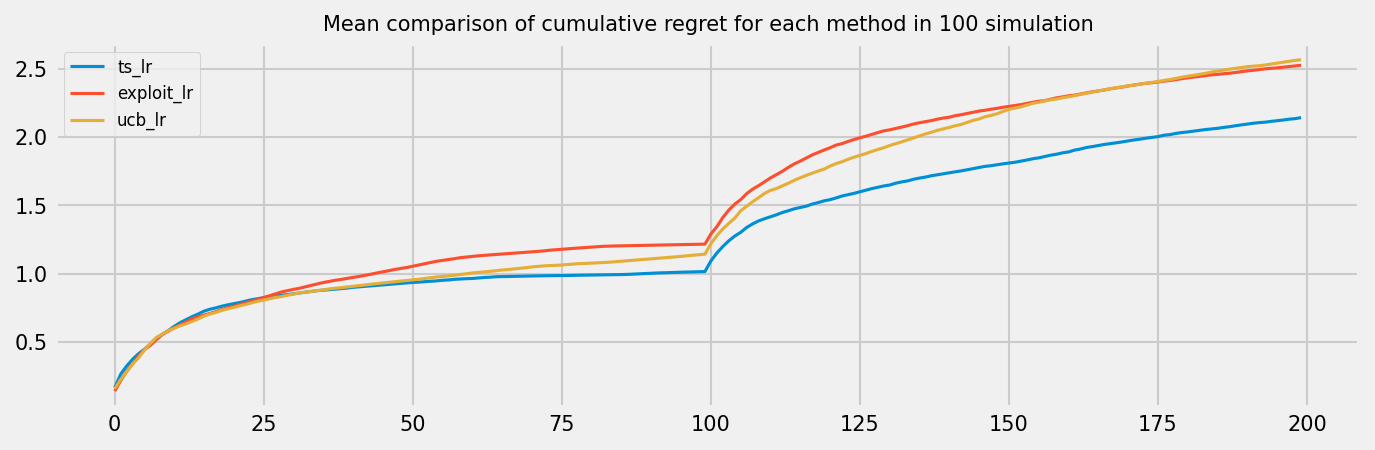

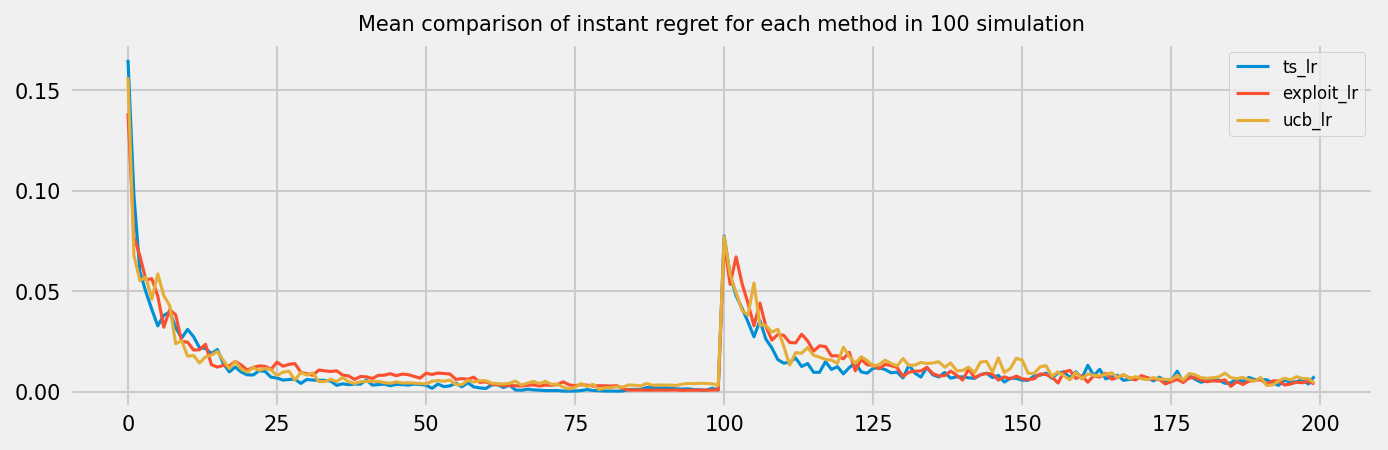

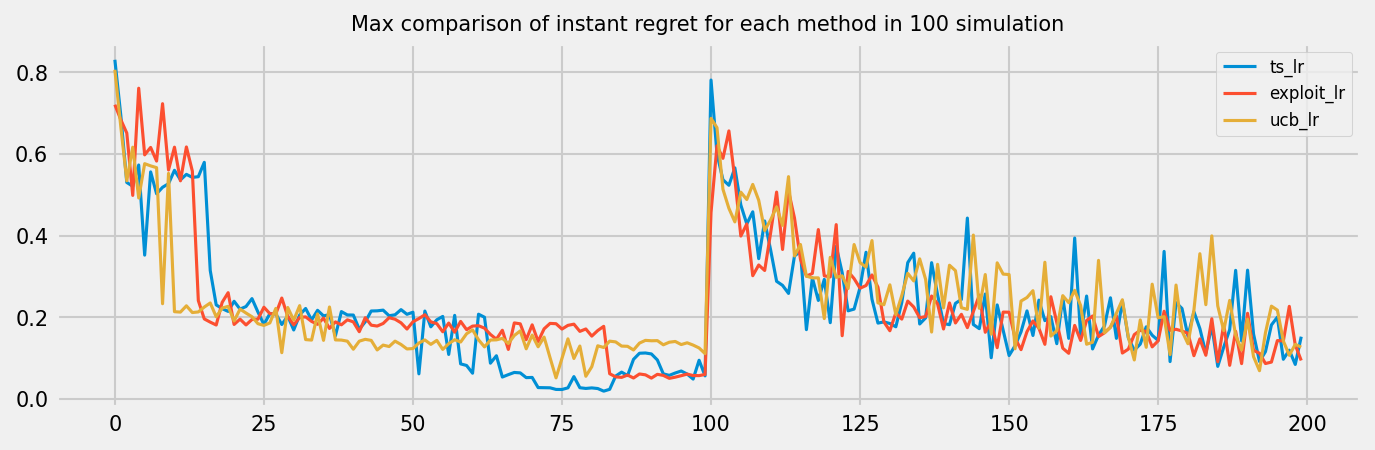

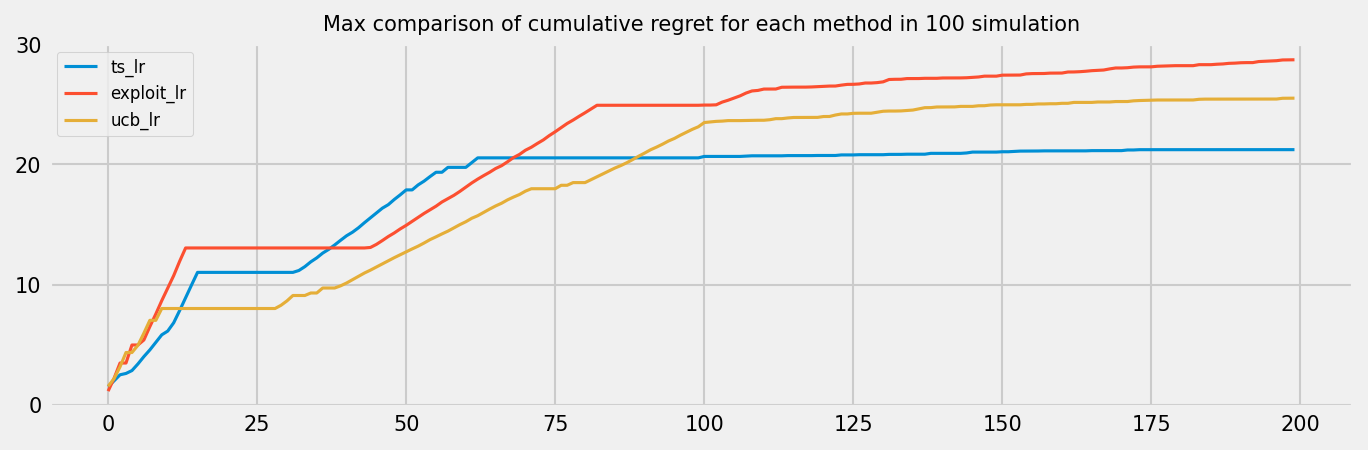

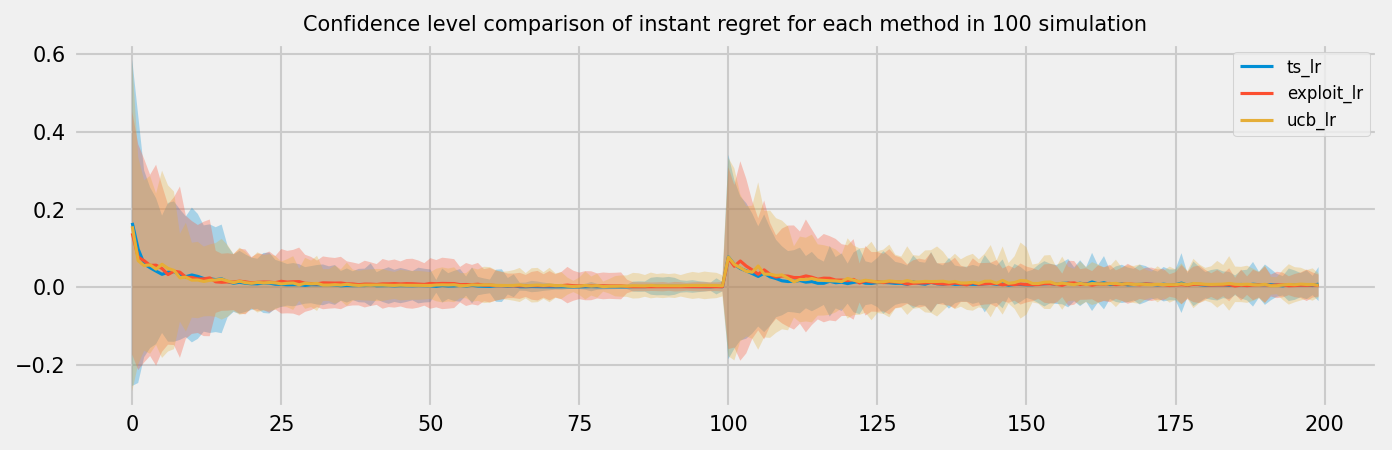

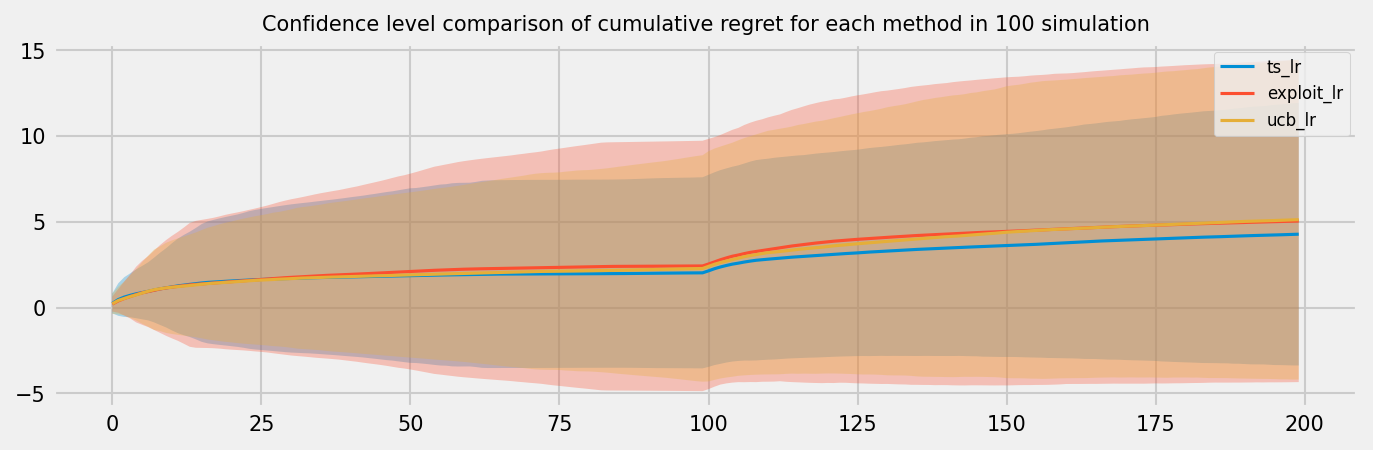

<Figure size 1500x450 with 0 Axes>

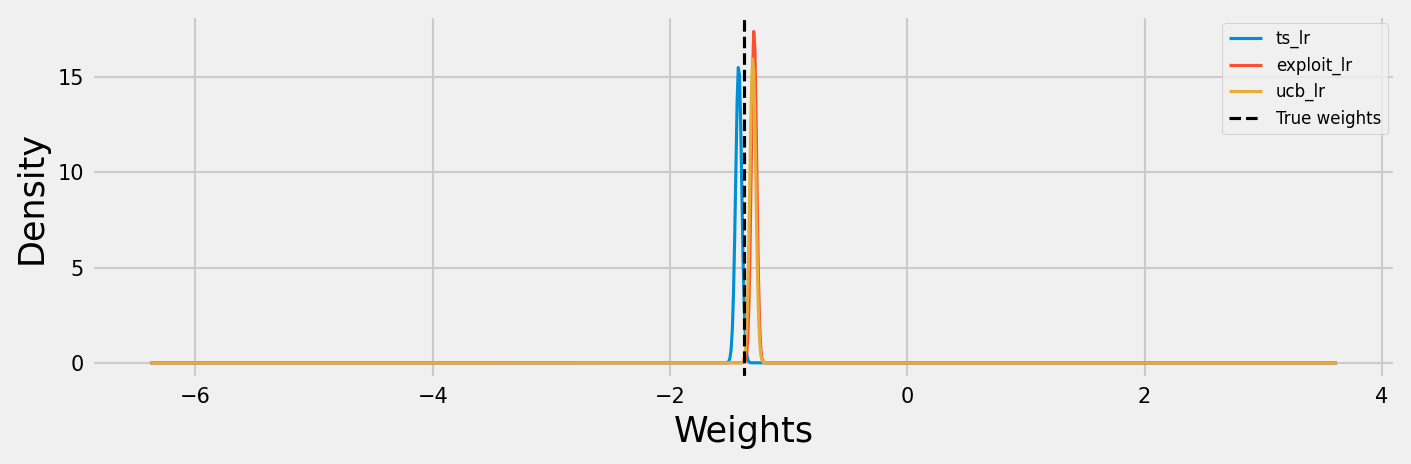

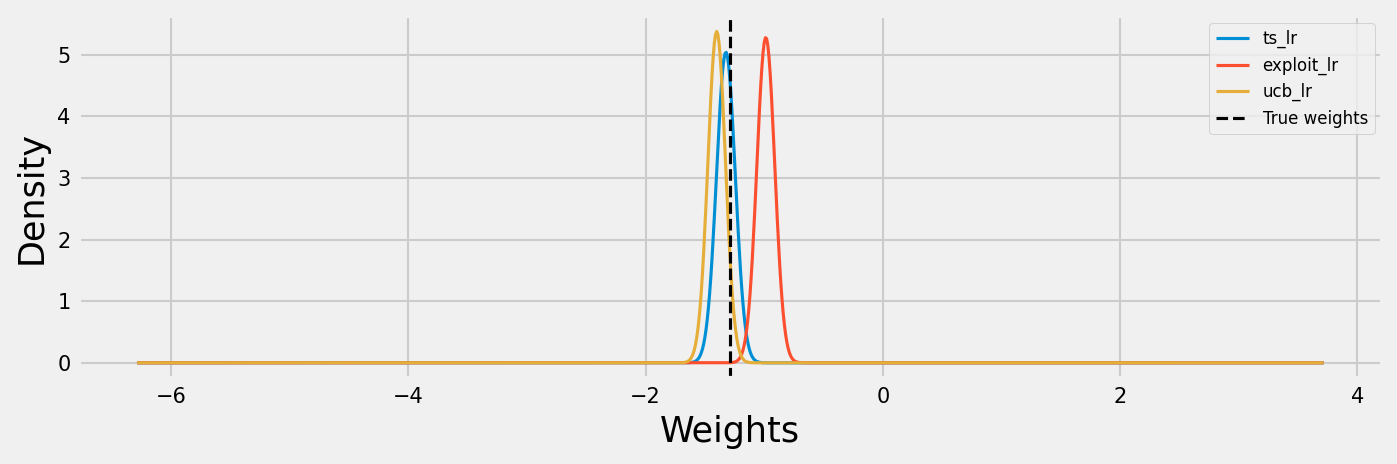

Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 1 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    5.423798
exploit_lr  199.0    4.633838
ucb_lr      199.0    4.640580
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 1 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    20.505572
exploit_lr  199.0     4.786947
ucb_lr      199.0    11.909693
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 1 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    7.077295
exploit_lr  199.0    7.015456
ucb_lr      199.0    5.854502
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 1 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    6.347443
exploit_lr  199.0    6.355035
ucb_lr

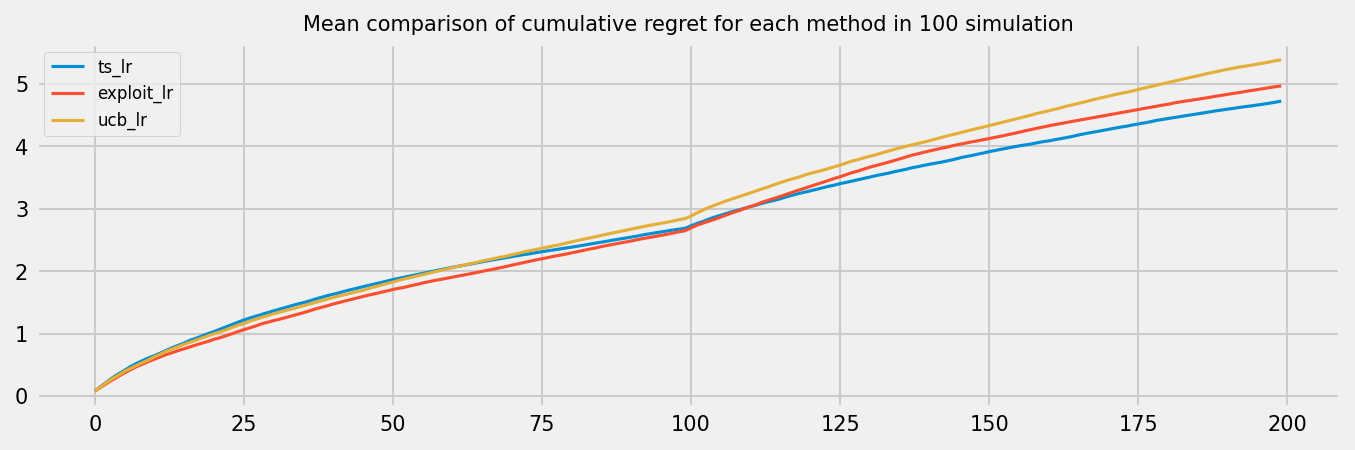

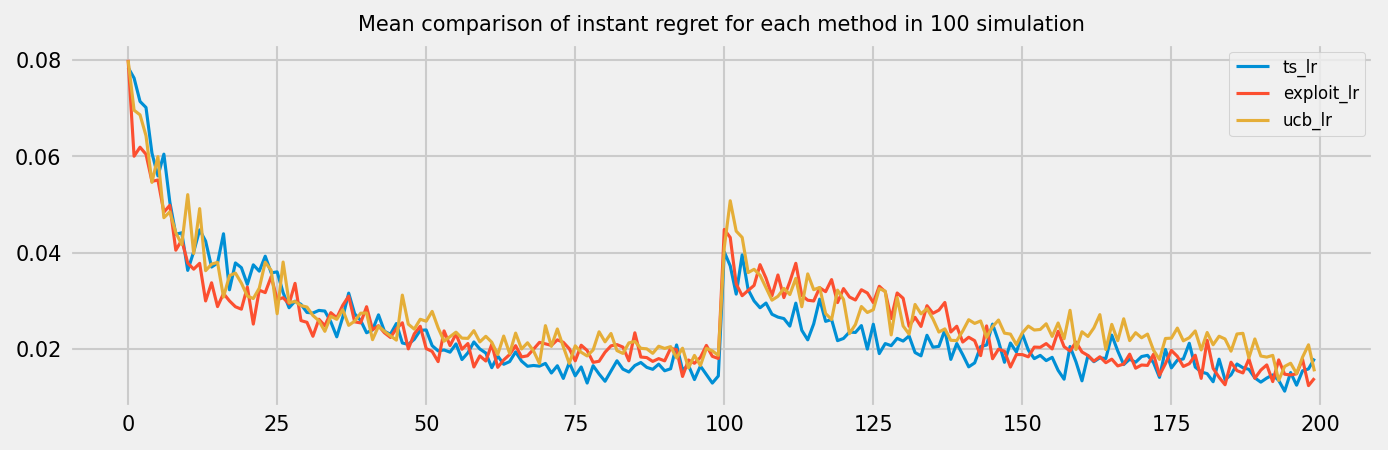

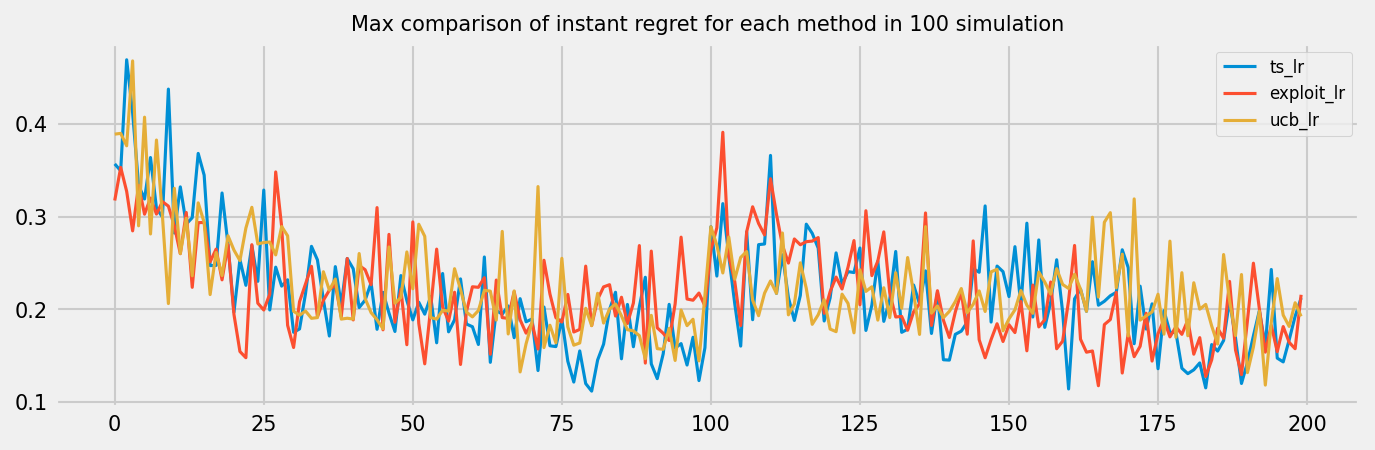

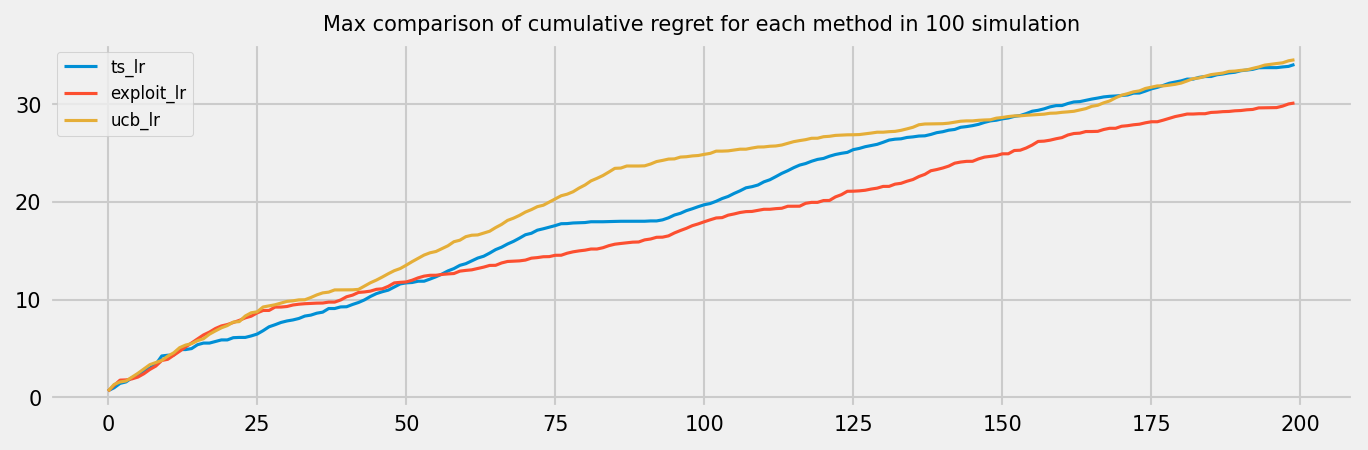

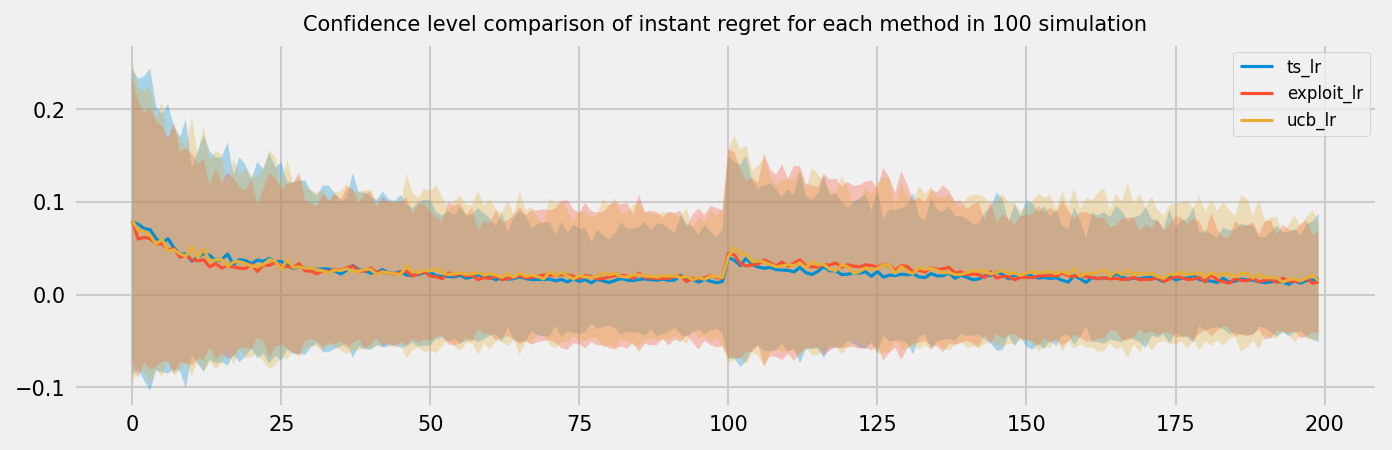

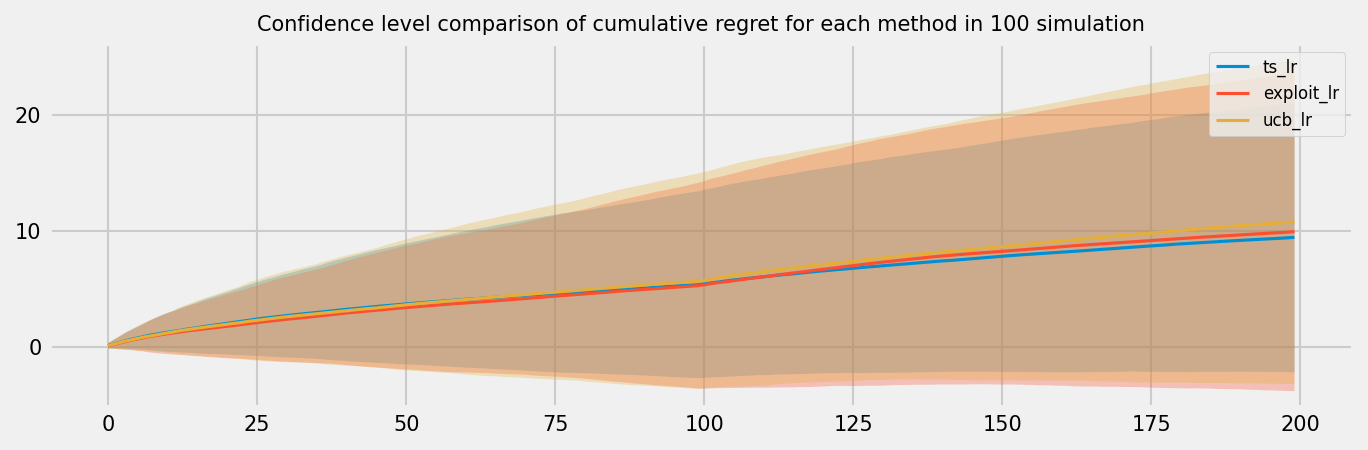

<Figure size 1500x450 with 0 Axes>

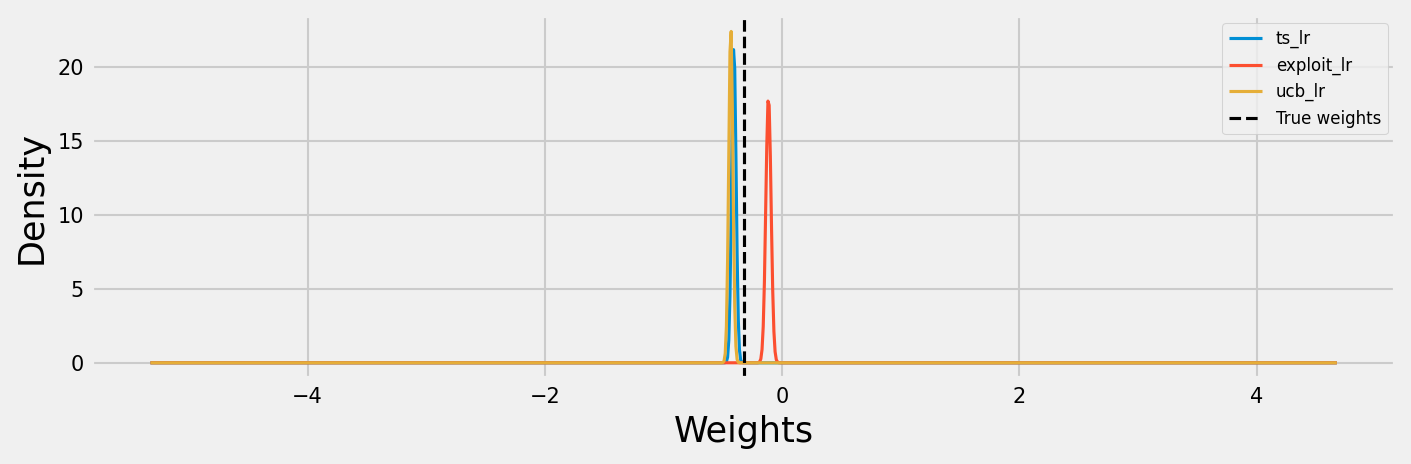

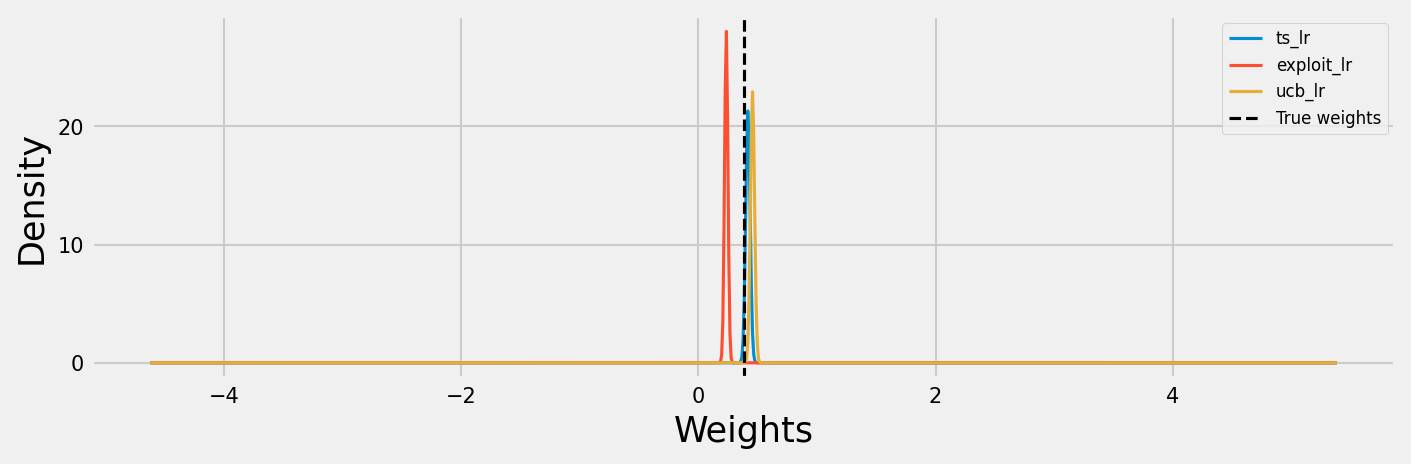

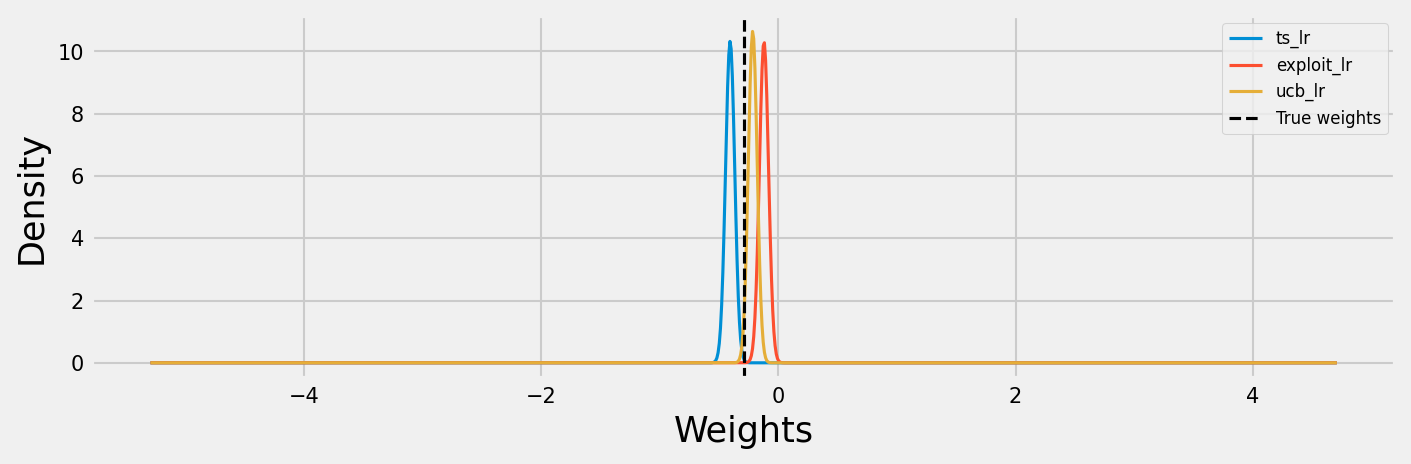

Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 2 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    21.669668
exploit_lr  199.0    11.791768
ucb_lr      199.0    17.368768
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    10.690180
exploit_lr  199.0    10.279768
ucb_lr      199.0    10.774884
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    12.107294
exploit_lr  199.0     9.999112
ucb_lr      199.0     9.360419
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    40.829975
exploit_lr  199.0    10.10521

In [11]:
# load the results from pickle
for i in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[i]
    print(f"Analyzing simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    try:
        experiment_df = pd.read_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
    except:
        print(f"File not found for {n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}")
        continue

    if winning_policy(experiment_df) != 'ts_lr':
        continue
    regret_mean = experiment_df.reset_index().groupby(['policy','round'], sort = False)['regret'].mean()
    plot_regret(regret_mean, n_sims, regret_type='cumulative')
    plot_regret(regret_mean, n_sims, regret_type='instant')

    #plot cf
    plot_regret_max(experiment_df, n_sims, regret_type='instant')
    plot_regret_max(experiment_df, n_sims, regret_type='cumulative')
    #plot max
    plot_regret_cl(experiment_df, n_sims, regret_type='instant')
    plot_regret_cl(experiment_df, n_sims, regret_type='cumulative')

    # #plot weights
    weights_df = get_weights(experiment_df)
    plot_weight_distribution(weights_df)
